In [9]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [10]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ESPECIALIADAD A.pdf'

In [11]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [12]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [13]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=107.4, y1=114.8
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 212
Page 1, Q1, A: Yellow percentage: 0.0%


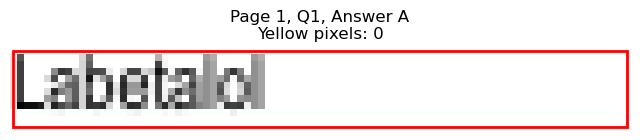

Page 1, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=115.9, y1=127.4
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 244
Page 1, Q1, B: Yellow percentage: 0.0%


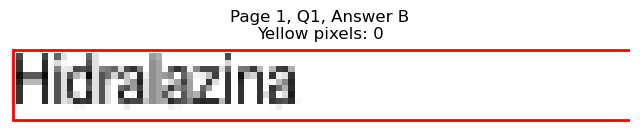

Page 1, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=381.1, y1=114.8
Page 1, Q1, C: Yellow pixels: 1050
Page 1, Q1, C: Total non-white pixels: 1260
Page 1, Q1, C: Yellow percentage: 83.3%


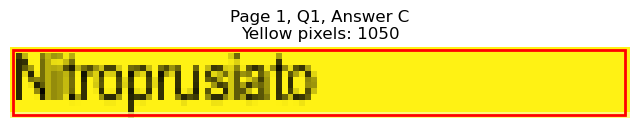

Page 1, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=382.7, y1=127.4
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 299
Page 1, Q1, D: Yellow percentage: 0.0%


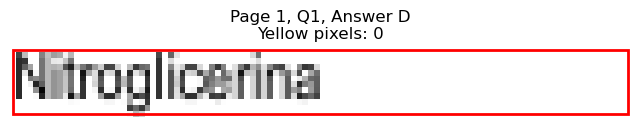


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=144.5, y1=177.9
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 419
Page 1, Q2, A: Yellow percentage: 0.0%


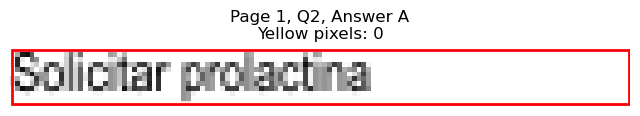

Page 1, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=118.9, y1=190.5
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 273
Page 1, Q2, B: Yellow percentage: 0.0%


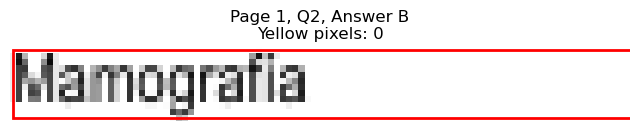

Page 1, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=413.3, y1=177.9
Page 1, Q2, C: Yellow pixels: 1
Page 1, Q2, C: Total non-white pixels: 569
Page 1, Q2, C: Yellow percentage: 0.2%


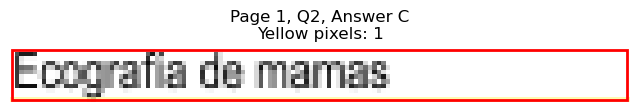

Page 1, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=380.6, y1=190.5
Page 1, Q2, D: Yellow pixels: 949
Page 1, Q2, D: Total non-white pixels: 1248
Page 1, Q2, D: Yellow percentage: 76.0%


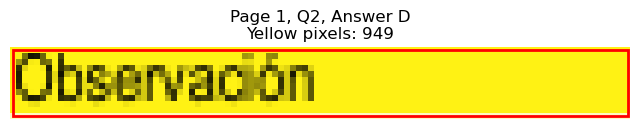


Page 1, Q2 - Selected Answer: D (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=126.5, y1=228.4
Page 1, Q3, A: Yellow pixels: 982
Page 1, Q3, A: Total non-white pixels: 1308
Page 1, Q3, A: Yellow percentage: 75.1%


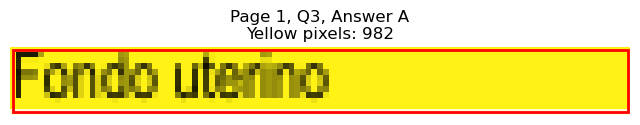

Page 1, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=179.6, y1=241.0
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 577
Page 1, Q3, B: Yellow percentage: 0.0%


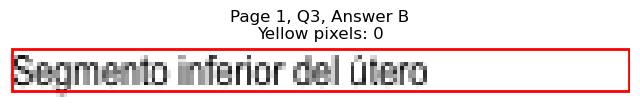

Page 1, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=385.7, y1=228.4
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 280
Page 1, Q3, C: Yellow percentage: 0.0%


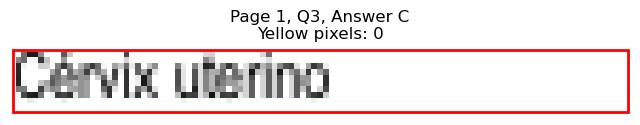

Page 1, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=389.6, y1=241.0
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 308
Page 1, Q3, D: Yellow percentage: 0.0%


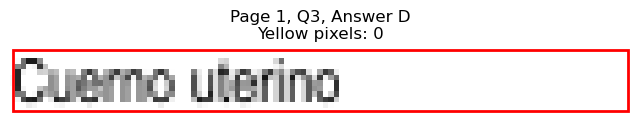


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=187.8, y1=316.8
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 613
Page 1, Q4, A: Yellow percentage: 0.0%


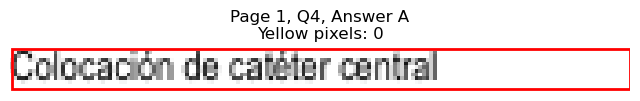

Page 1, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=162.6, y1=329.4
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 442
Page 1, Q4, B: Yellow percentage: 0.0%


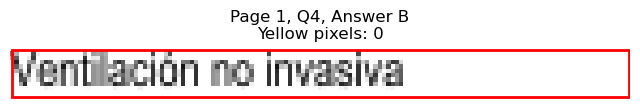

Page 1, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=429.4, y1=316.8
Page 1, Q4, C: Yellow pixels: 153
Page 1, Q4, C: Total non-white pixels: 691
Page 1, Q4, C: Yellow percentage: 22.1%


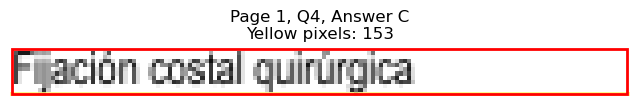

Page 1, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=419.8, y1=329.4
Page 1, Q4, D: Yellow pixels: 1199
Page 1, Q4, D: Total non-white pixels: 1716
Page 1, Q4, D: Yellow percentage: 69.9%


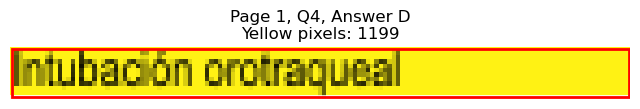


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=79.3, y1=379.9
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 36
Page 1, Q5, A: Yellow percentage: 0.0%


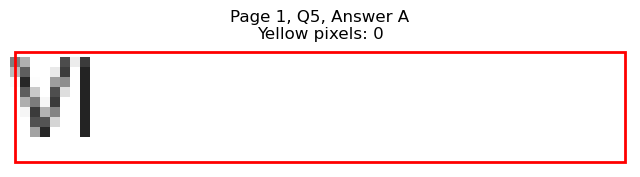

Page 1, Q5 - B: Detected box: x0=56.6, y0=381.4, x1=65.2, y1=392.5
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 50
Page 1, Q5, B: Yellow percentage: 0.0%


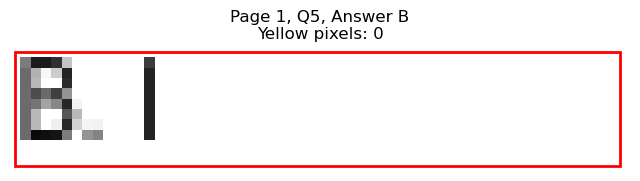

Page 1, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=337.6, y1=379.9
Page 1, Q5, C: Yellow pixels: 692
Page 1, Q5, C: Total non-white pixels: 732
Page 1, Q5, C: Yellow percentage: 94.5%


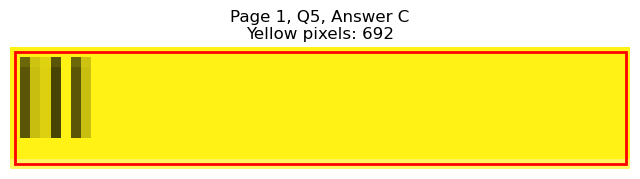

Page 1, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=338.5, y1=392.5
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 43
Page 1, Q5, D: Yellow percentage: 0.0%


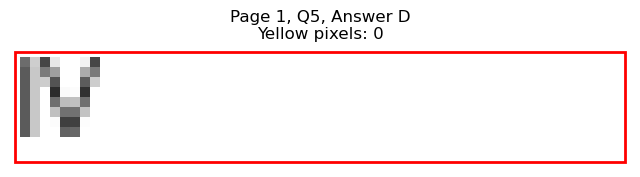


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=285.5, y1=468.2
Page 1, Q6, A: Yellow pixels: 268
Page 1, Q6, A: Total non-white pixels: 1639
Page 1, Q6, A: Yellow percentage: 16.4%


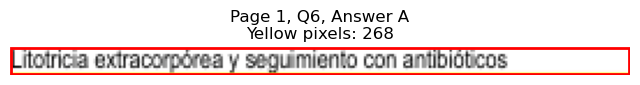

Page 1, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=365.2, y1=480.8
Page 1, Q6, B: Yellow pixels: 3092
Page 1, Q6, B: Total non-white pixels: 4176
Page 1, Q6, B: Yellow percentage: 74.0%


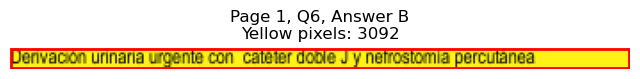

Page 1, Q6 - C: Detected box: x0=68.8, y0=482.5, x1=285.5, y1=493.5
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 1086
Page 1, Q6, C: Yellow percentage: 0.0%


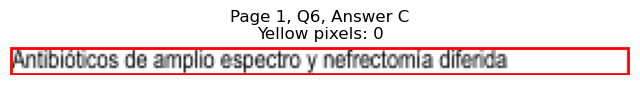

Page 1, Q6 - D: Detected box: x0=68.8, y0=495.1, x1=286.0, y1=506.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 1105
Page 1, Q6, D: Yellow percentage: 0.0%


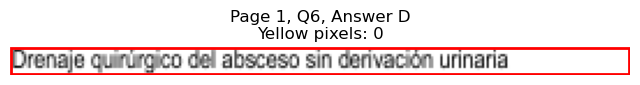


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=172.6, y1=569.2
Page 1, Q7, A: Yellow pixels: 155
Page 1, Q7, A: Total non-white pixels: 673
Page 1, Q7, A: Yellow percentage: 23.0%


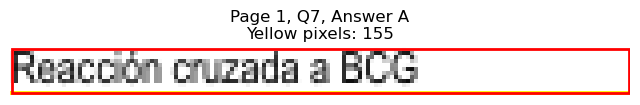

Page 1, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=236.8, y1=581.8
Page 1, Q7, B: Yellow pixels: 1900
Page 1, Q7, B: Total non-white pixels: 2568
Page 1, Q7, B: Yellow percentage: 74.0%


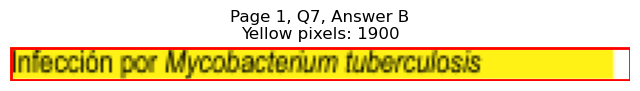

Page 1, Q7 - C: Detected box: x0=327.5, y0=558.2, x1=509.0, y1=569.2
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 923
Page 1, Q7, C: Yellow percentage: 0.0%


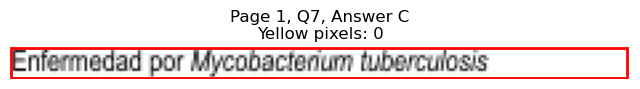

Page 1, Q7 - D: Detected box: x0=327.5, y0=570.8, x1=495.5, y1=581.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 872
Page 1, Q7, D: Yellow percentage: 0.0%


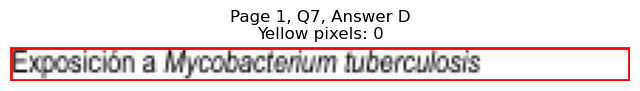


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=246.8, y1=645.0
Page 1, Q8, A: Yellow pixels: 2036
Page 1, Q8, A: Total non-white pixels: 2748
Page 1, Q8, A: Yellow percentage: 74.1%


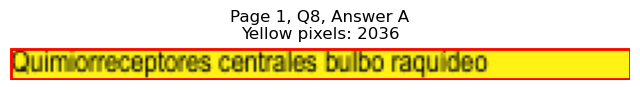

Page 1, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=190.1, y1=657.6
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 643
Page 1, Q8, B: Yellow percentage: 0.0%


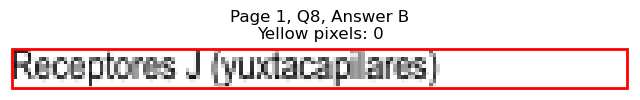

Page 1, Q8 - C: Detected box: x0=68.8, y0=659.1, x1=221.8, y1=670.2
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 784
Page 1, Q8, C: Yellow percentage: 0.0%


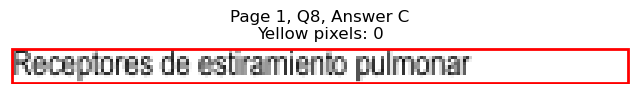

Page 1, Q8 - D: Detected box: x0=68.8, y0=671.7, x1=336.5, y1=682.8
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 1366
Page 1, Q8, D: Yellow percentage: 0.0%


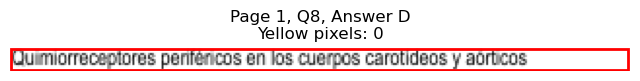


Page 1, Q8 - Selected Answer: A (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=747.4, x1=121.4, y1=758.5
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 269
Page 1, Q9, A: Yellow percentage: 0.0%


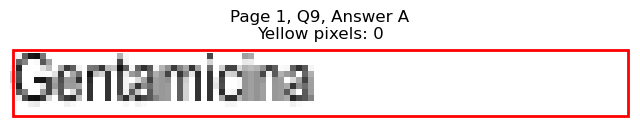

Page 1, Q9 - B: Detected box: x0=68.3, y0=760.2, x1=132.5, y1=771.2
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 341
Page 1, Q9, B: Yellow percentage: 0.0%


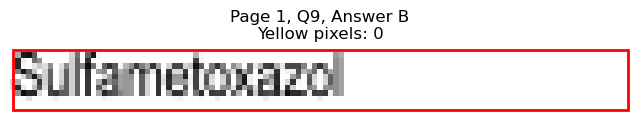

Page 1, Q9 - C: Detected box: x0=327.5, y0=747.4, x1=368.6, y1=758.5
Page 1, Q9, C: Yellow pixels: 862
Page 1, Q9, C: Total non-white pixels: 1104
Page 1, Q9, C: Yellow percentage: 78.1%


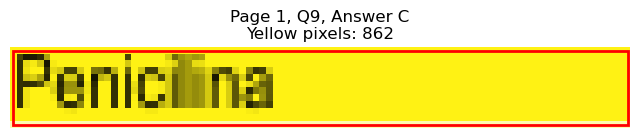

Page 1, Q9 - D: Detected box: x0=327.5, y0=760.2, x1=381.6, y1=771.2
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 283
Page 1, Q9, D: Yellow percentage: 0.0%


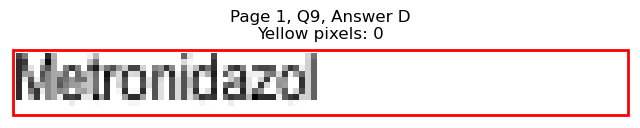


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=171.1, y1=127.4
Page 2, Q1, A: Yellow pixels: 1300
Page 2, Q1, A: Total non-white pixels: 1848
Page 2, Q1, A: Yellow percentage: 70.3%


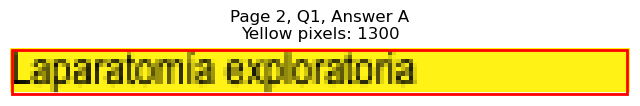

Page 2, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=173.6, y1=140.0
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 522
Page 2, Q1, B: Yellow percentage: 0.0%


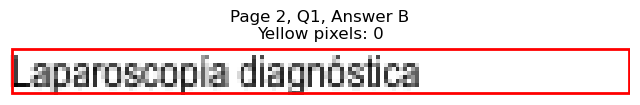

Page 2, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=426.8, y1=127.4
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 512
Page 2, Q1, C: Yellow percentage: 0.0%


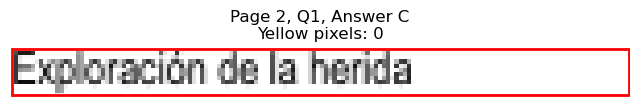

Page 2, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=353.0, y1=140.0
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 119
Page 2, Q1, D: Yellow percentage: 0.0%


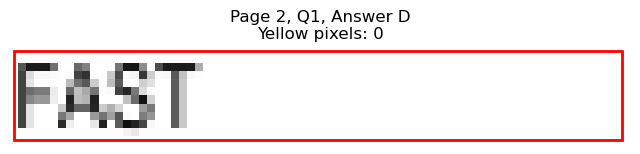


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=155.5, y1=203.1
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 429
Page 2, Q2, A: Yellow percentage: 0.0%


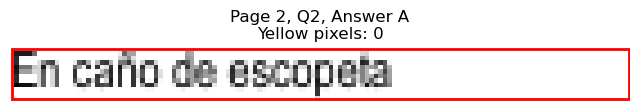

Page 2, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=172.6, y1=215.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 526
Page 2, Q2, B: Yellow percentage: 0.0%


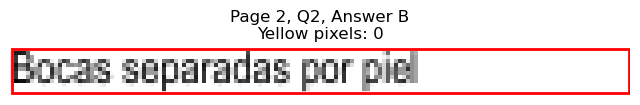

Page 2, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=393.2, y1=203.1
Page 2, Q2, C: Yellow pixels: 117
Page 2, Q2, C: Total non-white pixels: 548
Page 2, Q2, C: Yellow percentage: 21.4%


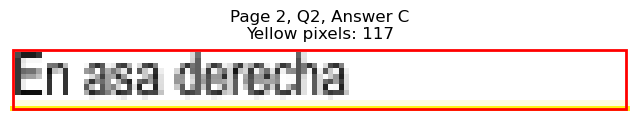

Page 2, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=397.2, y1=215.7
Page 2, Q2, D: Yellow pixels: 1216
Page 2, Q2, D: Total non-white pixels: 1452
Page 2, Q2, D: Yellow percentage: 83.7%


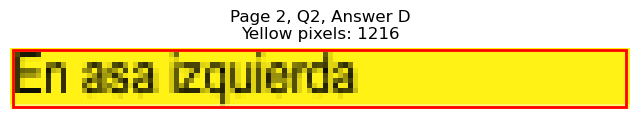


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=152.0, y1=291.6
Page 2, Q3, A: Yellow pixels: 1149
Page 2, Q3, A: Total non-white pixels: 1620
Page 2, Q3, A: Yellow percentage: 70.9%


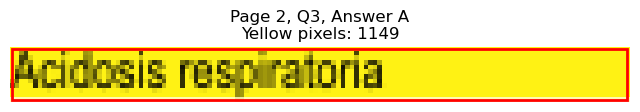

Page 2, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=141.5, y1=304.2
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 369
Page 2, Q3, B: Yellow percentage: 0.0%


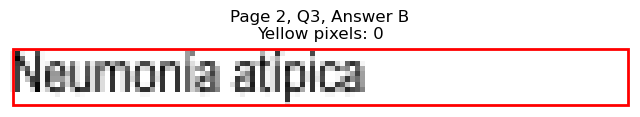

Page 2, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=401.6, y1=291.6
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 385
Page 2, Q3, C: Yellow percentage: 0.0%


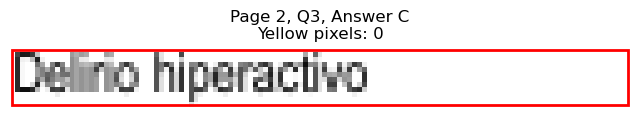

Page 2, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=416.8, y1=304.2
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 452
Page 2, Q3, D: Yellow percentage: 0.0%


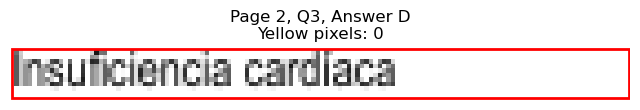


Page 2, Q3 - Selected Answer: A (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=155.2, y1=367.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 439
Page 2, Q4, A: Yellow percentage: 0.0%


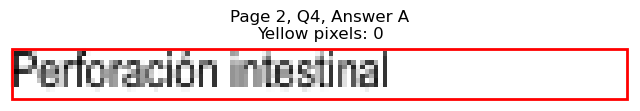

Page 2, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=161.5, y1=379.9
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 437
Page 2, Q4, B: Yellow percentage: 0.0%


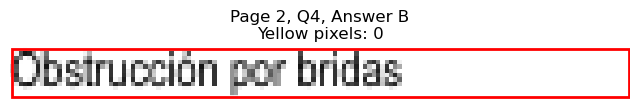

Page 2, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=383.6, y1=367.3
Page 2, Q4, C: Yellow pixels: 953
Page 2, Q4, C: Total non-white pixels: 1284
Page 2, Q4, C: Yellow percentage: 74.2%


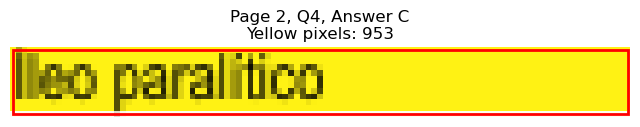

Page 2, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=411.7, y1=379.9
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 440
Page 2, Q4, D: Yellow percentage: 0.0%


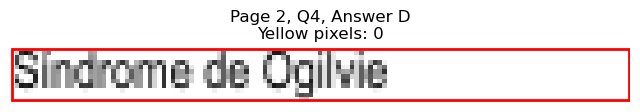


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=245.3, y1=430.4
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 838
Page 2, Q5, A: Yellow percentage: 0.0%


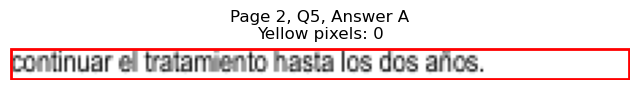

Page 2, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=219.7, y1=443.0
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 712
Page 2, Q5, B: Yellow percentage: 0.0%


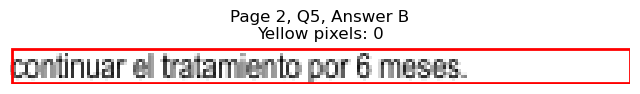

Page 2, Q5 - C: Detected box: x0=68.8, y0=444.6, x1=361.6, y1=455.6
Page 2, Q5, C: Yellow pixels: 344
Page 2, Q5, C: Total non-white pixels: 1810
Page 2, Q5, C: Yellow percentage: 19.0%


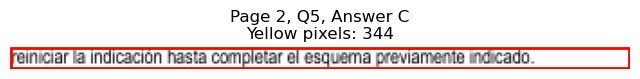

Page 2, Q5 - D: Detected box: x0=68.8, y0=457.2, x1=318.6, y1=468.2
Page 2, Q5, D: Yellow pixels: 2407
Page 2, Q5, D: Total non-white pixels: 3318
Page 2, Q5, D: Yellow percentage: 72.5%


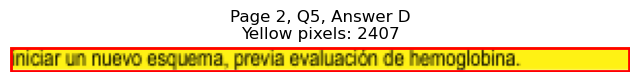


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=107.9, y1=531.3
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 177
Page 2, Q6, A: Yellow percentage: 0.0%


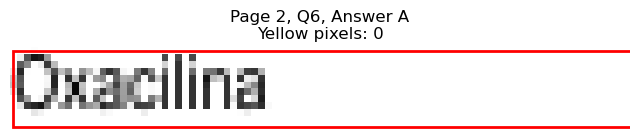

Page 2, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=116.9, y1=543.9
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 245
Page 2, Q6, B: Yellow percentage: 0.0%


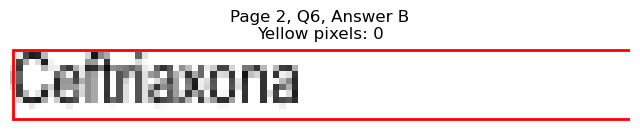

Page 2, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=371.2, y1=531.3
Page 2, Q6, C: Yellow pixels: 875
Page 2, Q6, C: Total non-white pixels: 1140
Page 2, Q6, C: Yellow percentage: 76.8%


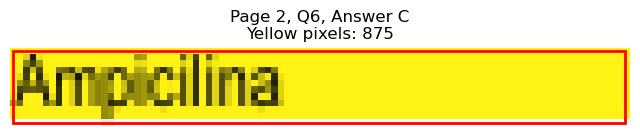

Page 2, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=363.6, y1=543.9
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 185
Page 2, Q6, D: Yellow percentage: 0.0%


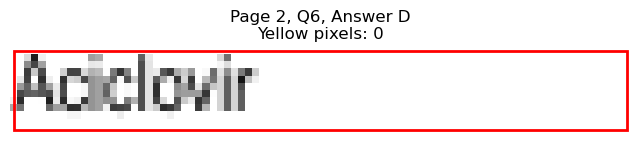


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=121.6, y1=594.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 278
Page 2, Q7, A: Yellow percentage: 0.0%


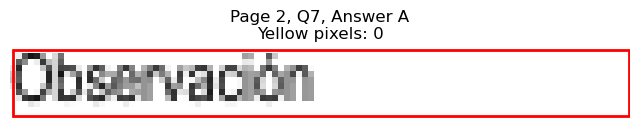

Page 2, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=129.5, y1=607.0
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 286
Page 2, Q7, B: Yellow percentage: 0.0%


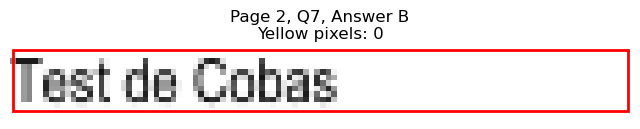

Page 2, Q7 - C: Detected box: x0=327.5, y0=583.4, x1=395.8, y1=594.4
Page 2, Q7, C: Yellow pixels: 119
Page 2, Q7, C: Total non-white pixels: 450
Page 2, Q7, C: Yellow percentage: 26.4%


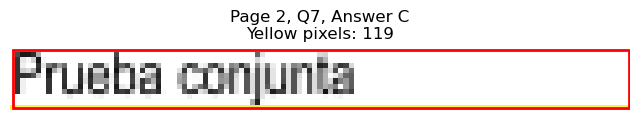

Page 2, Q7 - D: Detected box: x0=327.5, y0=596.0, x1=398.6, y1=607.0
Page 2, Q7, D: Yellow pixels: 1190
Page 2, Q7, D: Total non-white pixels: 1466
Page 2, Q7, D: Yellow percentage: 81.2%


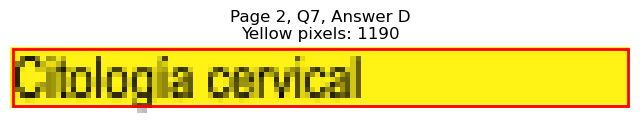


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=183.6, y1=670.2
Page 2, Q8, A: Yellow pixels: 166
Page 2, Q8, A: Total non-white pixels: 902
Page 2, Q8, A: Yellow percentage: 18.4%


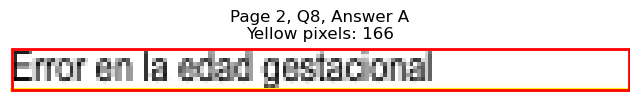

Page 2, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=233.8, y1=682.8
Page 2, Q8, B: Yellow pixels: 1923
Page 2, Q8, B: Total non-white pixels: 2568
Page 2, Q8, B: Yellow percentage: 74.9%


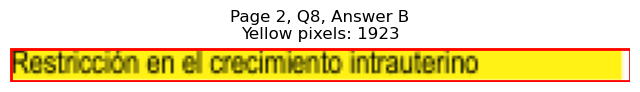

Page 2, Q8 - C: Detected box: x0=327.5, y0=659.1, x1=521.0, y1=670.2
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 976
Page 2, Q8, C: Yellow percentage: 0.0%


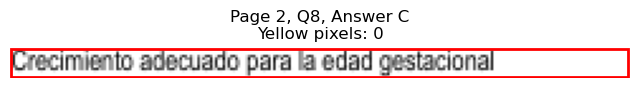

Page 2, Q8 - D: Detected box: x0=327.5, y0=671.7, x1=466.9, y1=682.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 699
Page 2, Q8, D: Yellow percentage: 0.0%


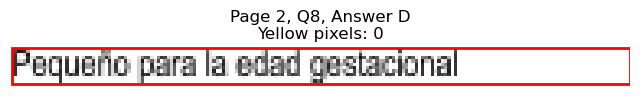


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=142.6, y1=733.3
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 374
Page 2, Q9, A: Yellow percentage: 0.0%


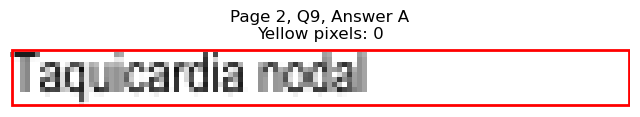

Page 2, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=184.7, y1=745.9
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 575
Page 2, Q9, B: Yellow percentage: 0.0%


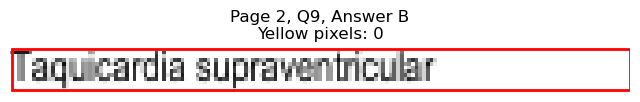

Page 2, Q9 - C: Detected box: x0=327.5, y0=722.2, x1=407.8, y1=733.3
Page 2, Q9, C: Yellow pixels: 1138
Page 2, Q9, C: Total non-white pixels: 1572
Page 2, Q9, C: Yellow percentage: 72.4%


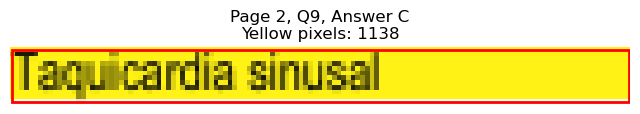

Page 2, Q9 - D: Detected box: x0=327.5, y0=734.8, x1=411.9, y1=745.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 456
Page 2, Q9, D: Yellow percentage: 0.0%


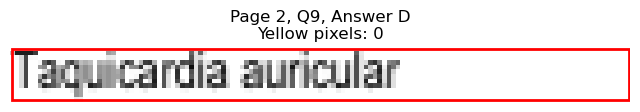


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=127.9, y1=140.0
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 397
Page 3, Q1, A: Yellow percentage: 0.0%


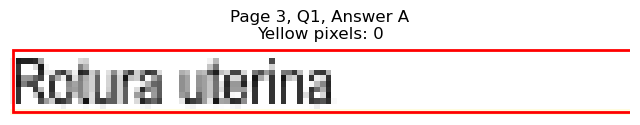

Page 3, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=207.1, y1=152.7
Page 3, Q1, B: Yellow pixels: 1760
Page 3, Q1, B: Total non-white pixels: 2280
Page 3, Q1, B: Yellow percentage: 77.2%


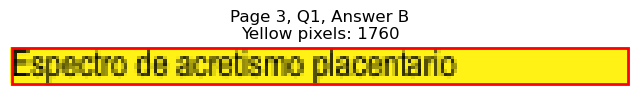

Page 3, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=439.3, y1=140.0
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 581
Page 3, Q1, C: Yellow percentage: 0.0%


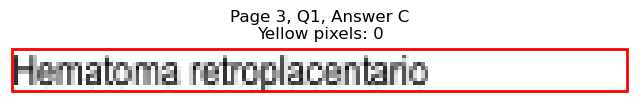

Page 3, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=418.2, y1=152.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 440
Page 3, Q1, D: Yellow percentage: 0.0%


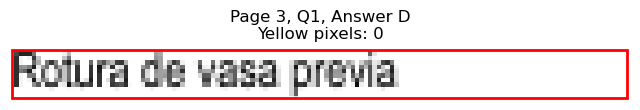


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=175.1, y1=203.1
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 540
Page 3, Q2, A: Yellow percentage: 0.0%


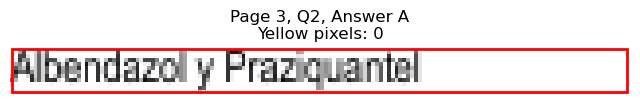

Page 3, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=121.0, y1=215.7
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 288
Page 3, Q2, B: Yellow percentage: 0.0%


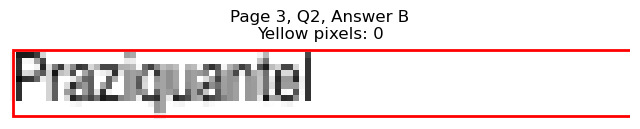

Page 3, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=375.6, y1=203.1
Page 3, Q2, C: Yellow pixels: 99
Page 3, Q2, C: Total non-white pixels: 419
Page 3, Q2, C: Yellow percentage: 23.6%


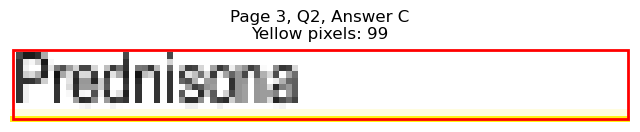

Page 3, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=374.8, y1=215.7
Page 3, Q2, D: Yellow pixels: 1000
Page 3, Q2, D: Total non-white pixels: 1176
Page 3, Q2, D: Yellow percentage: 85.0%


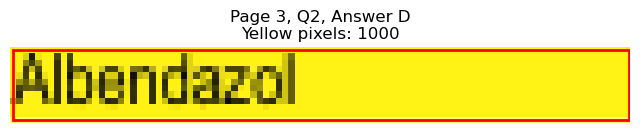


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=175.6, y1=266.2
Page 3, Q3, A: Yellow pixels: 158
Page 3, Q3, A: Total non-white pixels: 717
Page 3, Q3, A: Yellow percentage: 22.0%


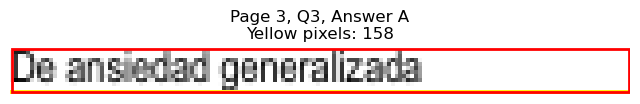

Page 3, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=118.9, y1=278.8
Page 3, Q3, B: Yellow pixels: 1029
Page 3, Q3, B: Total non-white pixels: 1212
Page 3, Q3, B: Yellow percentage: 84.9%


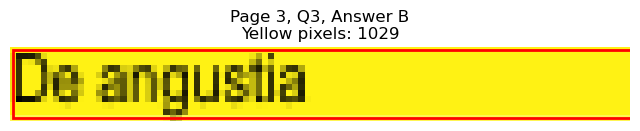

Page 3, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=415.2, y1=266.2
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 443
Page 3, Q3, C: Yellow percentage: 0.0%


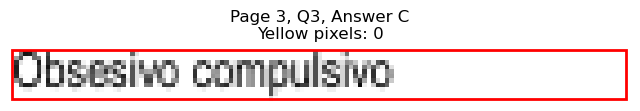

Page 3, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=357.1, y1=278.8
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 150
Page 3, Q3, D: Yellow percentage: 0.0%


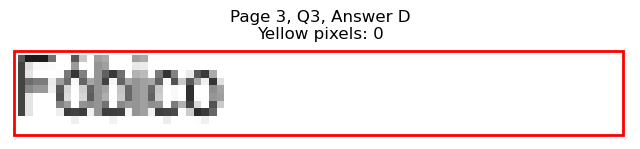


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=301.0, y1=342.0
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 1120
Page 3, Q4, A: Yellow percentage: 0.0%


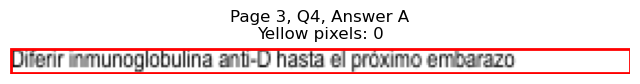

Page 3, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=218.6, y1=354.7
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 792
Page 3, Q4, B: Yellow percentage: 0.0%


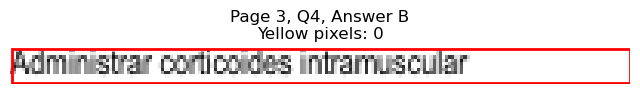

Page 3, Q4 - C: Detected box: x0=68.8, y0=356.2, x1=217.2, y1=367.3
Page 3, Q4, C: Yellow pixels: 200
Page 3, Q4, C: Total non-white pixels: 920
Page 3, Q4, C: Yellow percentage: 21.7%


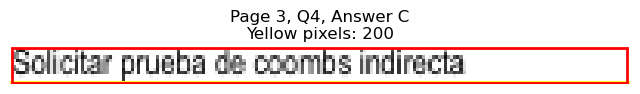

Page 3, Q4 - D: Detected box: x0=68.8, y0=368.8, x1=263.9, y1=379.9
Page 3, Q4, D: Yellow pixels: 2154
Page 3, Q4, D: Total non-white pixels: 2952
Page 3, Q4, D: Yellow percentage: 73.0%


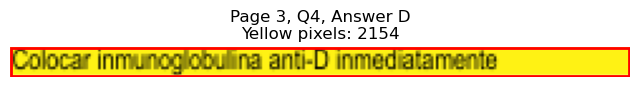


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=118.9, y1=443.0
Page 3, Q5, A: Yellow pixels: 1000
Page 3, Q5, A: Total non-white pixels: 1212
Page 3, Q5, A: Yellow percentage: 82.5%


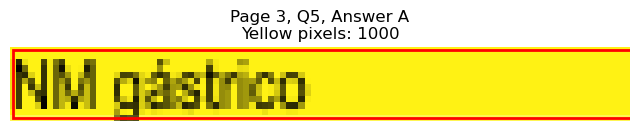

Page 3, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=136.4, y1=455.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 353
Page 3, Q5, B: Yellow percentage: 0.0%


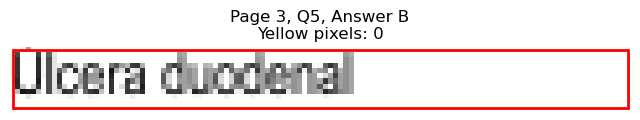

Page 3, Q5 - C: Detected box: x0=327.5, y0=432.0, x1=396.2, y1=443.0
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 332
Page 3, Q5, C: Yellow percentage: 0.0%


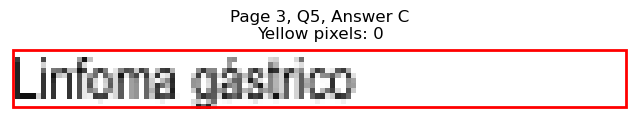

Page 3, Q5 - D: Detected box: x0=327.5, y0=444.6, x1=408.7, y1=455.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 388
Page 3, Q5, D: Yellow percentage: 0.0%


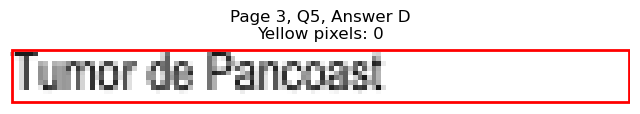


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=507.7, x1=79.3, y1=518.7
Page 3, Q6, A: Yellow pixels: 711
Page 3, Q6, A: Total non-white pixels: 744
Page 3, Q6, A: Yellow percentage: 95.6%


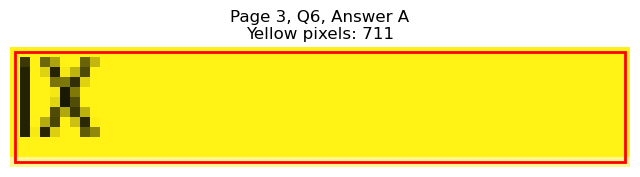

Page 3, Q6 - B: Detected box: x0=68.3, y0=520.3, x1=81.8, y1=531.3
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 52
Page 3, Q6, B: Yellow percentage: 0.0%


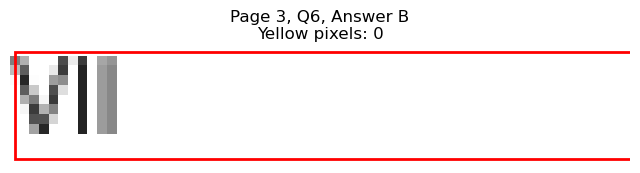

Page 3, Q6 - C: Detected box: x0=327.5, y0=507.7, x1=338.5, y1=518.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 50
Page 3, Q6, C: Yellow percentage: 0.0%


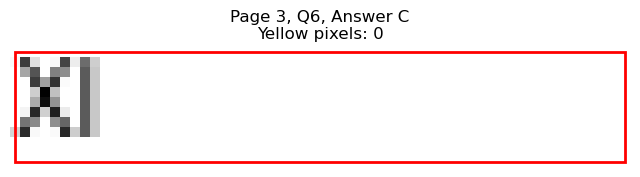

Page 3, Q6 - D: Detected box: x0=327.5, y0=520.3, x1=341.0, y1=531.3
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 66
Page 3, Q6, D: Yellow percentage: 0.0%


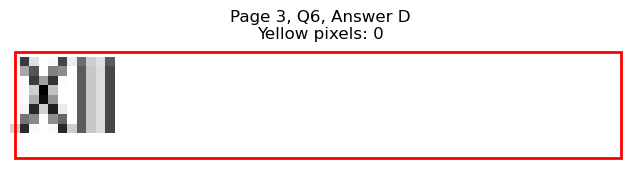


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=306.1, y1=594.4
Page 3, Q7, A: Yellow pixels: 2238
Page 3, Q7, A: Total non-white pixels: 3468
Page 3, Q7, A: Yellow percentage: 64.5%


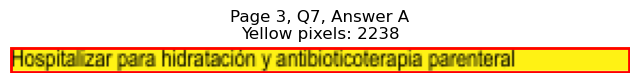

Page 3, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=314.0, y1=607.0
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1239
Page 3, Q7, B: Yellow percentage: 0.0%


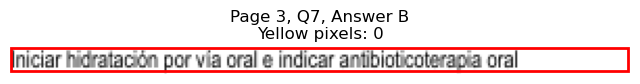

Page 3, Q7 - C: Detected box: x0=68.8, y0=608.6, x1=230.6, y1=619.6
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 847
Page 3, Q7, C: Yellow percentage: 0.0%


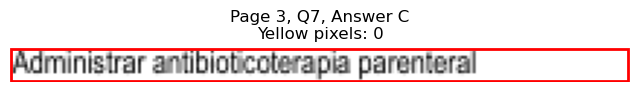

Page 3, Q7 - D: Detected box: x0=68.8, y0=621.3, x1=263.8, y1=632.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 1006
Page 3, Q7, D: Yellow percentage: 0.0%


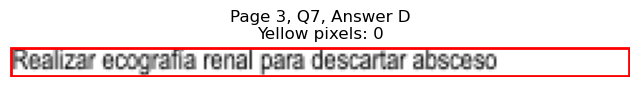


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=684.3, x1=96.8, y1=695.4
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 137
Page 3, Q8, A: Yellow percentage: 0.0%


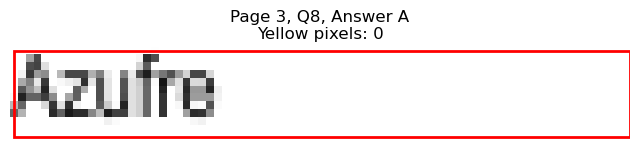

Page 3, Q8 - B: Detected box: x0=68.3, y0=697.0, x1=105.8, y1=708.1
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 196
Page 3, Q8, B: Yellow percentage: 0.0%


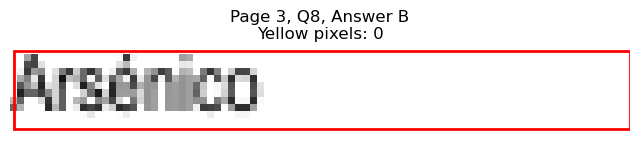

Page 3, Q8 - C: Detected box: x0=327.5, y0=684.3, x1=355.6, y1=695.4
Page 3, Q8, C: Yellow pixels: 775
Page 3, Q8, C: Total non-white pixels: 948
Page 3, Q8, C: Yellow percentage: 81.8%


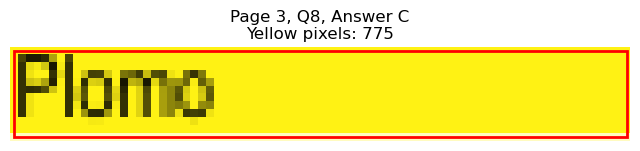

Page 3, Q8 - D: Detected box: x0=327.5, y0=697.0, x1=356.0, y1=708.1
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 135
Page 3, Q8, D: Yellow percentage: 0.0%


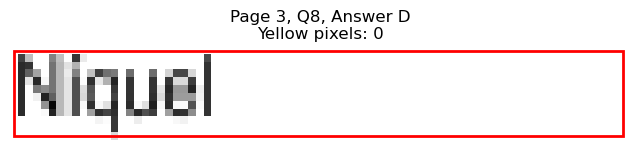


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=240.7, y1=127.4
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 863
Page 4, Q1, A: Yellow percentage: 0.0%


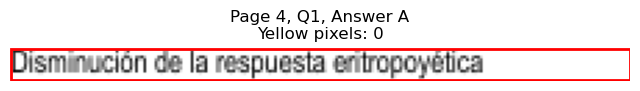

Page 4, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=225.7, y1=140.0
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 788
Page 4, Q1, B: Yellow percentage: 0.0%


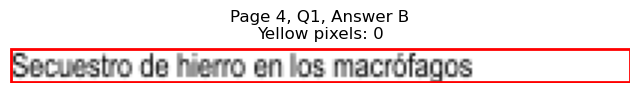

Page 4, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=484.9, y1=127.4
Page 4, Q1, C: Yellow pixels: 208
Page 4, Q1, C: Total non-white pixels: 978
Page 4, Q1, C: Yellow percentage: 21.3%


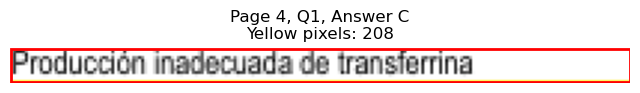

Page 4, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=429.4, y1=140.0
Page 4, Q1, D: Yellow pixels: 1462
Page 4, Q1, D: Total non-white pixels: 1836
Page 4, Q1, D: Yellow percentage: 79.6%


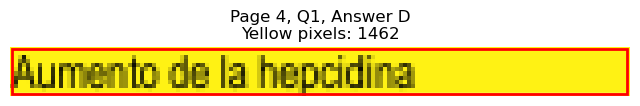


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=131.5, y1=190.5
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 312
Page 4, Q2, A: Yellow percentage: 0.0%


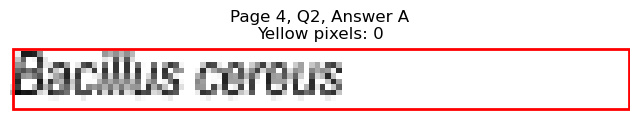

Page 4, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=136.0, y1=203.1
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 329
Page 4, Q2, B: Yellow percentage: 0.0%


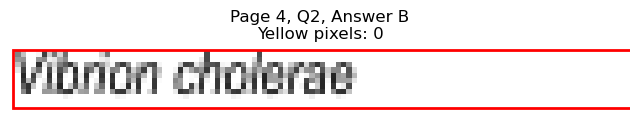

Page 4, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=423.2, y1=190.5
Page 4, Q2, C: Yellow pixels: 1256
Page 4, Q2, C: Total non-white pixels: 1764
Page 4, Q2, C: Yellow percentage: 71.2%


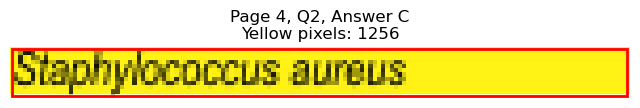

Page 4, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=414.2, y1=203.1
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 468
Page 4, Q2, D: Yellow percentage: 0.0%


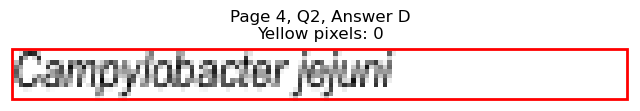


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=440.0, y1=266.2
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 1866
Page 4, Q3, A: Yellow percentage: 0.0%


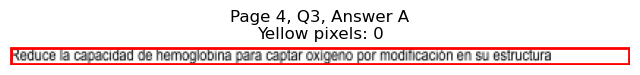

Page 4, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=391.3, y1=278.8
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 1964
Page 4, Q3, B: Yellow percentage: 0.0%


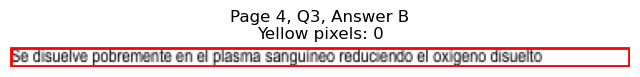

Page 4, Q3 - C: Detected box: x0=68.8, y0=280.5, x1=295.0, y1=291.6
Page 4, Q3, C: Yellow pixels: 2226
Page 4, Q3, C: Total non-white pixels: 3324
Page 4, Q3, C: Yellow percentage: 67.0%


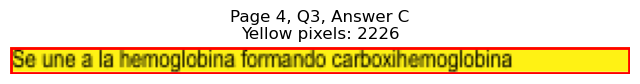

Page 4, Q3 - D: Detected box: x0=68.8, y0=293.1, x1=348.1, y1=304.2
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 1361
Page 4, Q3, D: Yellow percentage: 0.0%


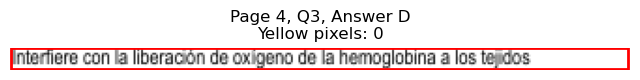


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=368.8, x1=180.2, y1=379.9
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 572
Page 4, Q4, A: Yellow percentage: 0.0%


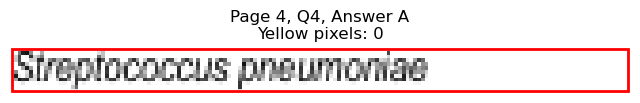

Page 4, Q4 - B: Detected box: x0=68.3, y0=381.4, x1=191.6, y1=392.5
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 612
Page 4, Q4, B: Yellow percentage: 0.0%


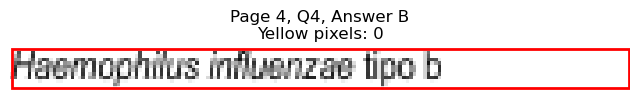

Page 4, Q4 - C: Detected box: x0=327.5, y0=368.8, x1=430.3, y1=379.9
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 673
Page 4, Q4, C: Yellow percentage: 0.0%


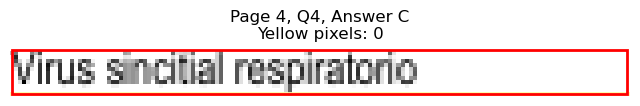

Page 4, Q4 - D: Detected box: x0=327.5, y0=381.4, x1=432.8, y1=392.5
Page 4, Q4, D: Yellow pixels: 1300
Page 4, Q4, D: Total non-white pixels: 1872
Page 4, Q4, D: Yellow percentage: 69.4%


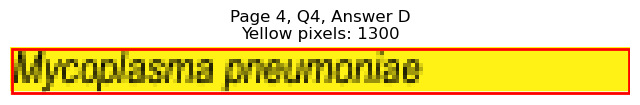


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=444.6, x1=114.5, y1=455.6
Page 4, Q5, A: Yellow pixels: 97
Page 4, Q5, A: Total non-white pixels: 316
Page 4, Q5, A: Yellow percentage: 30.7%


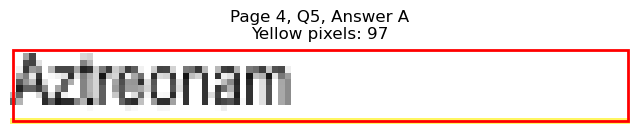

Page 4, Q5 - B: Detected box: x0=68.3, y0=457.2, x1=115.0, y1=468.2
Page 4, Q5, B: Yellow pixels: 882
Page 4, Q5, B: Total non-white pixels: 1069
Page 4, Q5, B: Yellow percentage: 82.5%


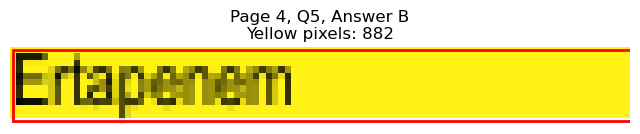

Page 4, Q5 - C: Detected box: x0=327.5, y0=444.6, x1=375.6, y1=455.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 255
Page 4, Q5, C: Yellow percentage: 0.0%


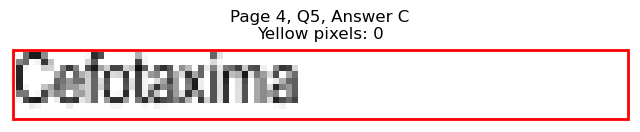

Page 4, Q5 - D: Detected box: x0=327.5, y0=457.2, x1=376.1, y1=468.2
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 255
Page 4, Q5, D: Yellow percentage: 0.0%


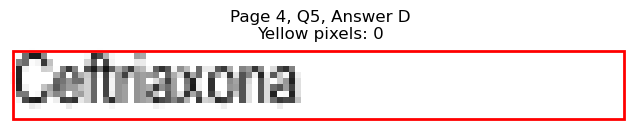


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=532.9, x1=197.2, y1=543.9
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 691
Page 4, Q6, A: Yellow percentage: 0.0%


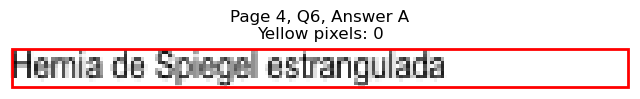

Page 4, Q6 - B: Detected box: x0=68.3, y0=545.5, x1=174.1, y1=556.5
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 533
Page 4, Q6, B: Yellow percentage: 0.0%


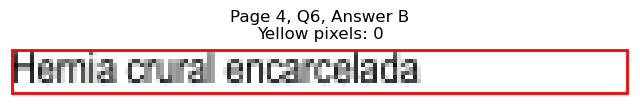

Page 4, Q6 - C: Detected box: x0=327.5, y0=532.9, x1=444.8, y1=543.9
Page 4, Q6, C: Yellow pixels: 1550
Page 4, Q6, C: Total non-white pixels: 2016
Page 4, Q6, C: Yellow percentage: 76.9%


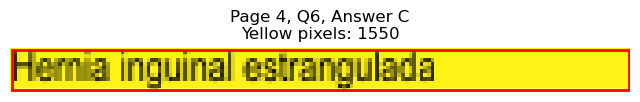

Page 4, Q6 - D: Detected box: x0=327.5, y0=545.5, x1=388.3, y1=556.5
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 310
Page 4, Q6, D: Yellow percentage: 0.0%


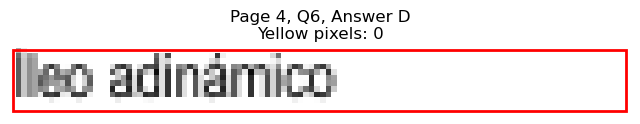


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=608.6, x1=210.2, y1=619.6
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 730
Page 4, Q7, A: Yellow percentage: 0.0%


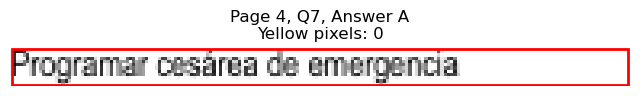

Page 4, Q7 - B: Detected box: x0=68.3, y0=621.3, x1=162.6, y1=632.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 467
Page 4, Q7, B: Yellow percentage: 0.0%


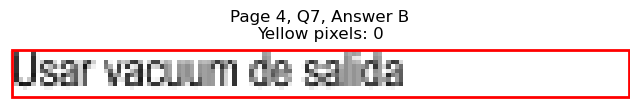

Page 4, Q7 - C: Detected box: x0=327.5, y0=608.6, x1=468.4, y1=619.6
Page 4, Q7, C: Yellow pixels: 192
Page 4, Q7, C: Total non-white pixels: 910
Page 4, Q7, C: Yellow percentage: 21.1%


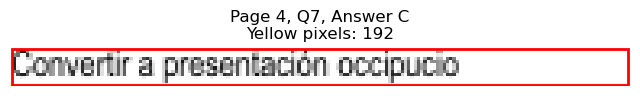

Page 4, Q7 - D: Detected box: x0=327.5, y0=621.3, x1=454.4, y1=632.4
Page 4, Q7, D: Yellow pixels: 1455
Page 4, Q7, D: Total non-white pixels: 2136
Page 4, Q7, D: Yellow percentage: 68.1%


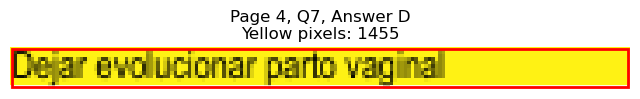


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=56.6, y0=684.3, x1=65.2, y1=695.4
Page 4, Q8, A: Yellow pixels: 606
Page 4, Q8, A: Total non-white pixels: 720
Page 4, Q8, A: Yellow percentage: 84.2%


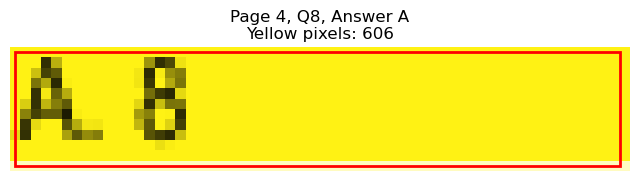

Page 4, Q8 - B: Detected box: x0=56.6, y0=697.0, x1=65.2, y1=708.1
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 78
Page 4, Q8, B: Yellow percentage: 0.0%


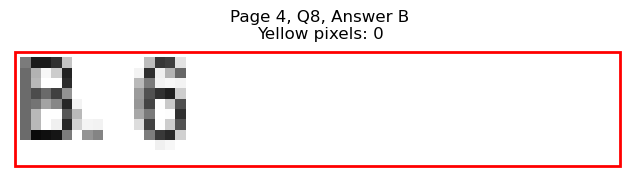

Page 4, Q8 - C: Detected box: x0=315.4, y0=684.3, x1=324.4, y1=695.4
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 67
Page 4, Q8, C: Yellow percentage: 0.0%


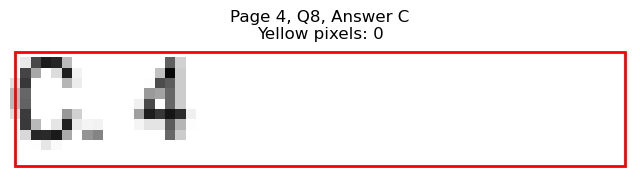

Page 4, Q8 - D: Detected box: x0=327.5, y0=697.0, x1=340.1, y1=708.1
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 45
Page 4, Q8, D: Yellow percentage: 0.0%


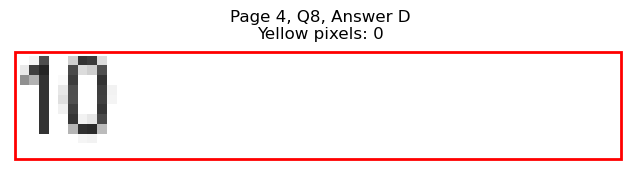


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=747.4, x1=109.4, y1=758.5
Page 4, Q9, A: Yellow pixels: 847
Page 4, Q9, A: Total non-white pixels: 1104
Page 4, Q9, A: Yellow percentage: 76.7%


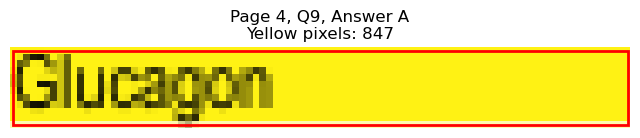

Page 4, Q9 - B: Detected box: x0=68.3, y0=760.2, x1=101.9, y1=771.2
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 133
Page 4, Q9, B: Yellow percentage: 0.0%


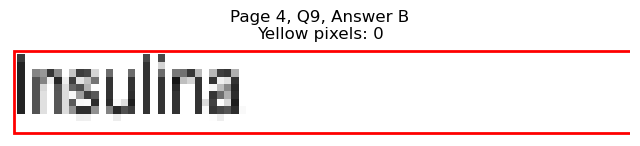

Page 4, Q9 - C: Detected box: x0=327.5, y0=747.4, x1=359.6, y1=758.5
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 156
Page 4, Q9, C: Yellow percentage: 0.0%


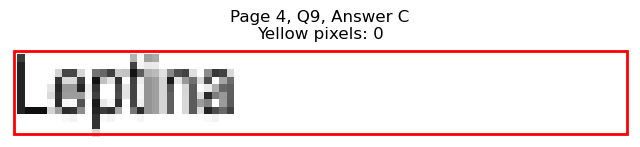

Page 4, Q9 - D: Detected box: x0=327.5, y0=760.2, x1=387.7, y1=771.2
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 320
Page 4, Q9, D: Yellow percentage: 0.0%


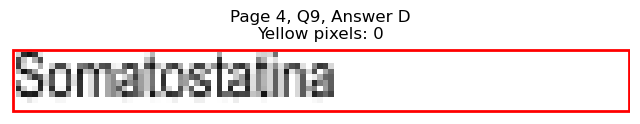


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=132.0, y1=127.4
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 340
Page 5, Q1, A: Yellow percentage: 0.0%


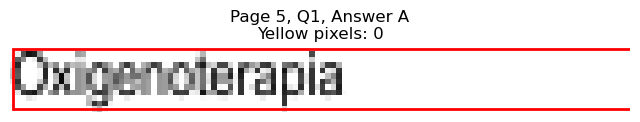

Page 5, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=113.4, y1=140.0
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 241
Page 5, Q1, B: Yellow percentage: 0.0%


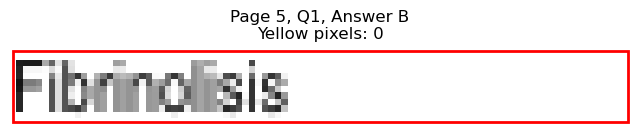

Page 5, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=415.2, y1=127.4
Page 5, Q1, C: Yellow pixels: 139
Page 5, Q1, C: Total non-white pixels: 625
Page 5, Q1, C: Yellow percentage: 22.2%


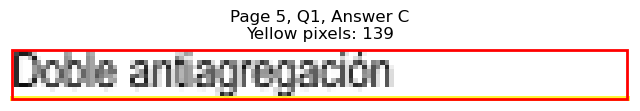

Page 5, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=419.3, y1=140.0
Page 5, Q1, D: Yellow pixels: 1380
Page 5, Q1, D: Total non-white pixels: 1716
Page 5, Q1, D: Yellow percentage: 80.4%


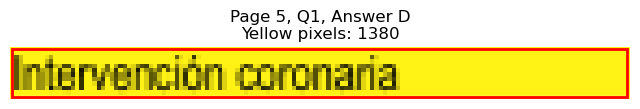


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=119.9, y1=203.1
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 246
Page 5, Q2, A: Yellow percentage: 0.0%


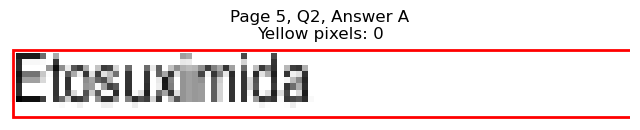

Page 5, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=122.5, y1=215.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 279
Page 5, Q2, B: Yellow percentage: 0.0%


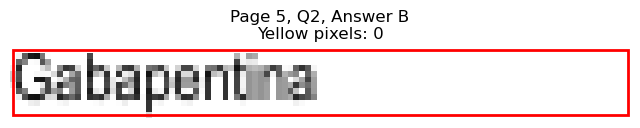

Page 5, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=367.6, y1=203.1
Page 5, Q2, C: Yellow pixels: 91
Page 5, Q2, C: Total non-white pixels: 393
Page 5, Q2, C: Yellow percentage: 23.2%


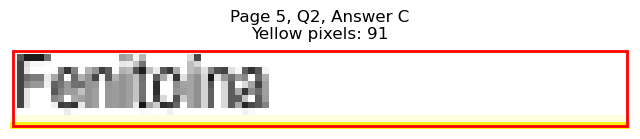

Page 5, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=368.6, y1=215.7
Page 5, Q2, D: Yellow pixels: 957
Page 5, Q2, D: Total non-white pixels: 1104
Page 5, Q2, D: Yellow percentage: 86.7%


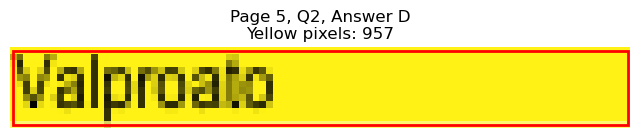


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=155.0, y1=266.2
Page 5, Q3, A: Yellow pixels: 138
Page 5, Q3, A: Total non-white pixels: 556
Page 5, Q3, A: Yellow percentage: 24.8%


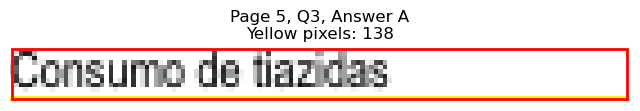

Page 5, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=184.1, y1=278.8
Page 5, Q3, B: Yellow pixels: 1534
Page 5, Q3, B: Total non-white pixels: 2004
Page 5, Q3, B: Yellow percentage: 76.5%


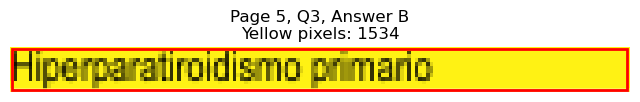

Page 5, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=420.7, y1=266.2
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 511
Page 5, Q3, C: Yellow percentage: 0.0%


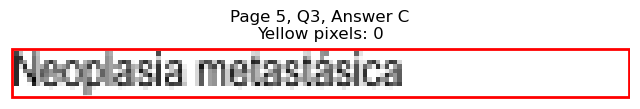

Page 5, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=452.9, y1=278.8
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 645
Page 5, Q3, D: Yellow percentage: 0.0%


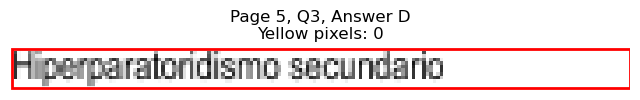


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=123.0, y1=316.8
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 296
Page 5, Q4, A: Yellow percentage: 0.0%


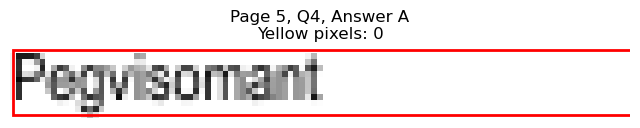

Page 5, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=119.4, y1=329.4
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 286
Page 5, Q4, B: Yellow percentage: 0.0%


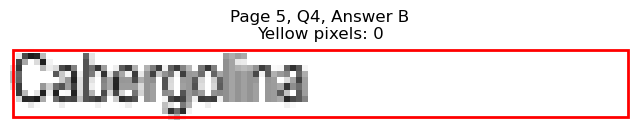

Page 5, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=371.6, y1=316.8
Page 5, Q4, C: Yellow pixels: 95
Page 5, Q4, C: Total non-white pixels: 336
Page 5, Q4, C: Yellow percentage: 28.3%


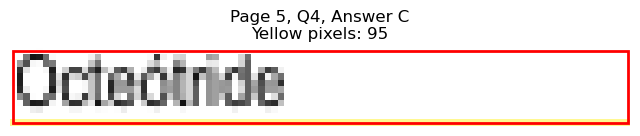

Page 5, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=406.7, y1=329.4
Page 5, Q4, D: Yellow pixels: 1147
Page 5, Q4, D: Total non-white pixels: 1560
Page 5, Q4, D: Yellow percentage: 73.5%


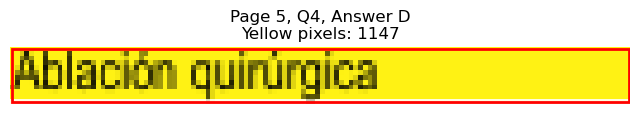


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=187.7, y1=392.5
Page 5, Q5, A: Yellow pixels: 1429
Page 5, Q5, A: Total non-white pixels: 2040
Page 5, Q5, A: Yellow percentage: 70.0%


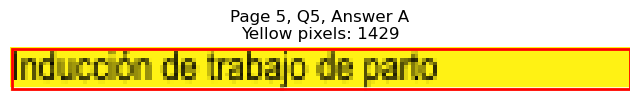

Page 5, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=178.1, y1=405.1
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 527
Page 5, Q5, B: Yellow percentage: 0.0%


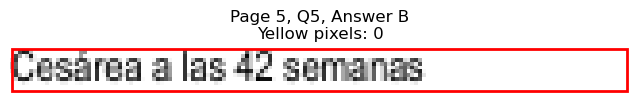

Page 5, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=447.8, y1=392.5
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 595
Page 5, Q5, C: Yellow percentage: 0.0%


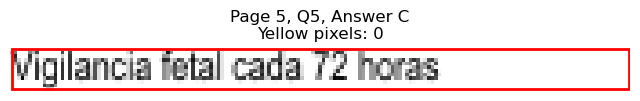

Page 5, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=426.2, y1=405.1
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 509
Page 5, Q5, D: Yellow percentage: 0.0%


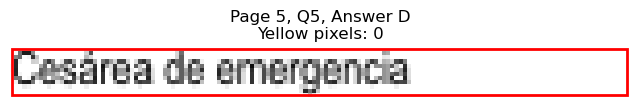


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=165.6, y1=455.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 492
Page 5, Q6, A: Yellow percentage: 0.0%


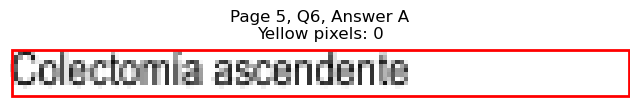

Page 5, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=112.4, y1=468.2
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 227
Page 5, Q6, B: Yellow percentage: 0.0%


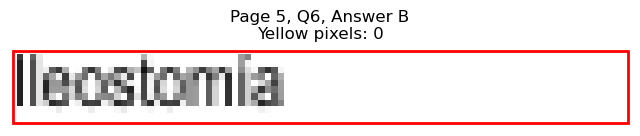

Page 5, Q6 - C: Detected box: x0=327.5, y0=444.6, x1=429.8, y1=455.6
Page 5, Q6, C: Yellow pixels: 153
Page 5, Q6, C: Total non-white pixels: 678
Page 5, Q6, C: Yellow percentage: 22.6%


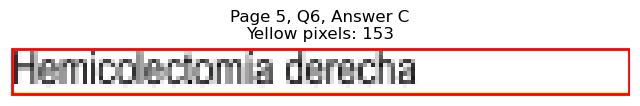

Page 5, Q6 - D: Detected box: x0=327.5, y0=457.2, x1=394.8, y1=468.2
Page 5, Q6, D: Yellow pixels: 1036
Page 5, Q6, D: Total non-white pixels: 1299
Page 5, Q6, D: Yellow percentage: 79.8%


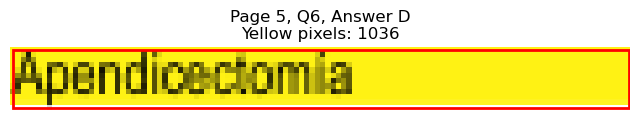


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=202.2, y1=518.7
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 665
Page 5, Q7, A: Yellow percentage: 0.0%


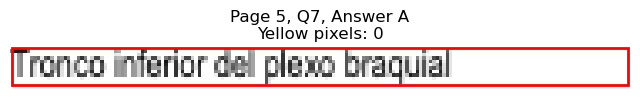

Page 5, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=230.9, y1=531.3
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 801
Page 5, Q7, B: Yellow percentage: 0.0%


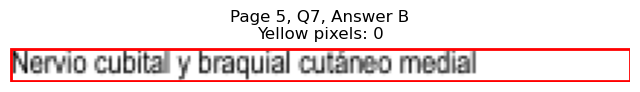

Page 5, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=466.4, y1=518.7
Page 5, Q7, C: Yellow pixels: 1727
Page 5, Q7, C: Total non-white pixels: 2280
Page 5, Q7, C: Yellow percentage: 75.7%


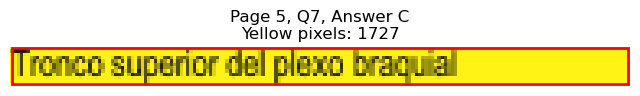

Page 5, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=458.4, y1=531.3
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 666
Page 5, Q7, D: Yellow percentage: 0.0%


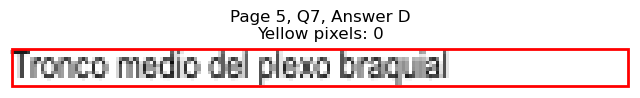


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=172.1, y1=569.2
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 558
Page 5, Q8, A: Yellow percentage: 0.0%


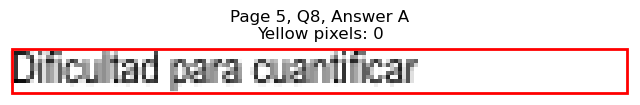

Page 5, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=155.0, y1=581.8
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 435
Page 5, Q8, B: Yellow percentage: 0.0%


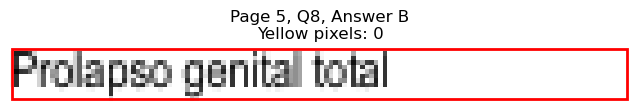

Page 5, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=455.4, y1=569.2
Page 5, Q8, C: Yellow pixels: 179
Page 5, Q8, C: Total non-white pixels: 831
Page 5, Q8, C: Yellow percentage: 21.5%


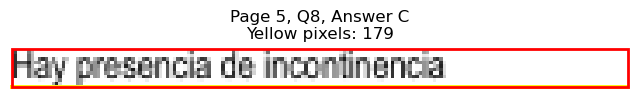

Page 5, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=384.6, y1=581.8
Page 5, Q8, D: Yellow pixels: 1098
Page 5, Q8, D: Total non-white pixels: 1296
Page 5, Q8, D: Yellow percentage: 84.7%


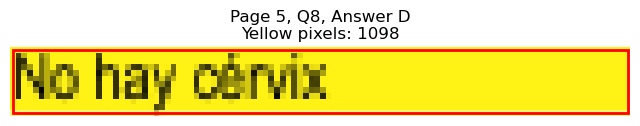


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=136.0, y1=645.0
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 498
Page 5, Q9, A: Yellow percentage: 0.0%


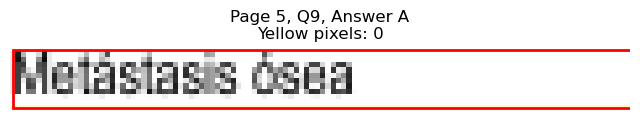

Page 5, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=160.1, y1=657.6
Page 5, Q9, B: Yellow pixels: 1190
Page 5, Q9, B: Total non-white pixels: 1716
Page 5, Q9, B: Yellow percentage: 69.3%


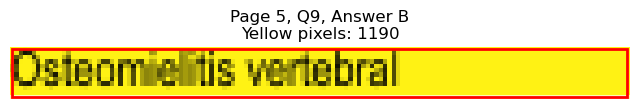

Page 5, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=399.2, y1=645.0
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 390
Page 5, Q9, C: Yellow percentage: 0.0%


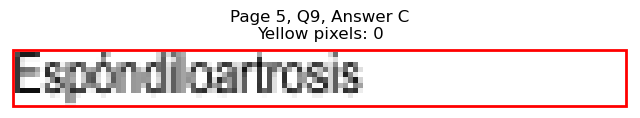

Page 5, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=419.4, y1=657.6
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 485
Page 5, Q9, D: Yellow percentage: 0.0%


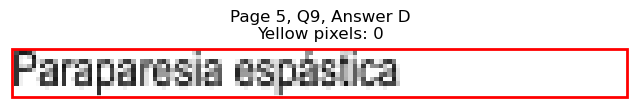


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=722.2, x1=138.1, y1=733.3
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 354
Page 5, Q10, A: Yellow percentage: 0.0%


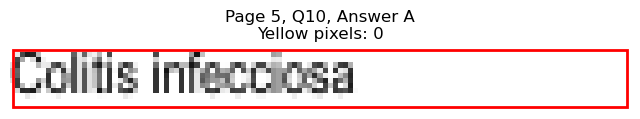

Page 5, Q10 - B: Detected box: x0=68.3, y0=734.8, x1=142.1, y1=745.9
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 376
Page 5, Q10, B: Yellow percentage: 0.0%


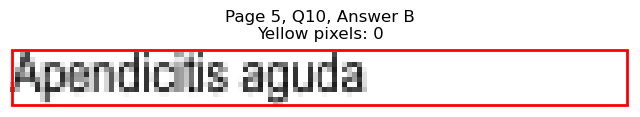

Page 5, Q10 - C: Detected box: x0=327.5, y0=722.2, x1=405.8, y1=733.3
Page 5, Q10, C: Yellow pixels: 1102
Page 5, Q10, C: Total non-white pixels: 1548
Page 5, Q10, C: Yellow percentage: 71.2%


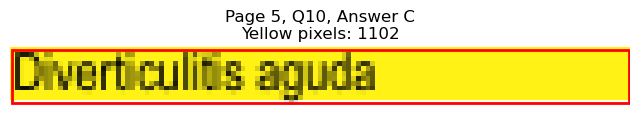

Page 5, Q10 - D: Detected box: x0=327.5, y0=734.8, x1=418.8, y1=745.9
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 448
Page 5, Q10, D: Yellow percentage: 0.0%


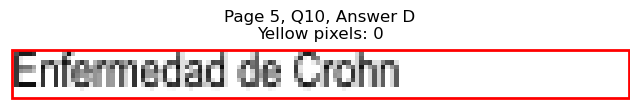


Page 5, Q10 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=115.0, y1=102.2
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 258
Page 6, Q1, A: Yellow percentage: 0.0%


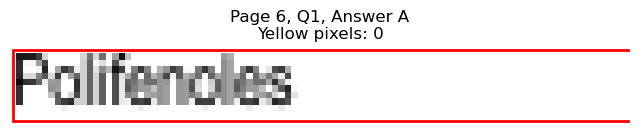

Page 6, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=95.9, y1=114.8
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 136
Page 6, Q1, B: Yellow percentage: 0.0%


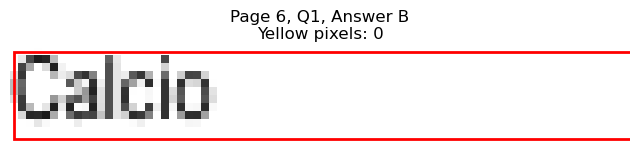

Page 6, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=365.0, y1=102.2
Page 6, Q1, C: Yellow pixels: 837
Page 6, Q1, C: Total non-white pixels: 979
Page 6, Q1, C: Yellow percentage: 85.5%


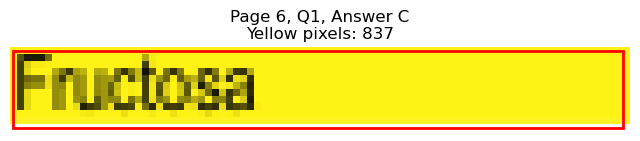

Page 6, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=365.6, y1=114.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 198
Page 6, Q1, D: Yellow percentage: 0.0%


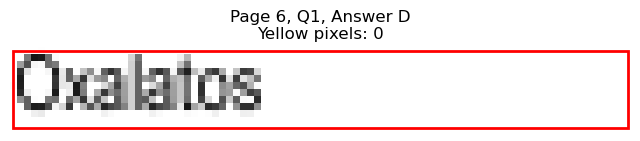


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=127.6, y1=177.9
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 343
Page 6, Q2, A: Yellow percentage: 0.0%


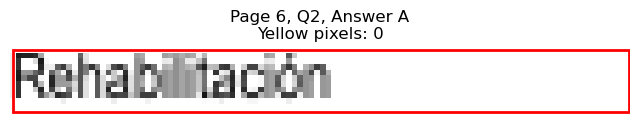

Page 6, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=116.0, y1=190.5
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 231
Page 6, Q2, B: Yellow percentage: 0.0%


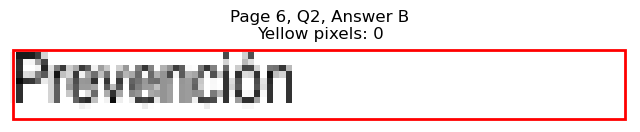

Page 6, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=373.1, y1=177.9
Page 6, Q2, C: Yellow pixels: 1008
Page 6, Q2, C: Total non-white pixels: 1164
Page 6, Q2, C: Yellow percentage: 86.6%


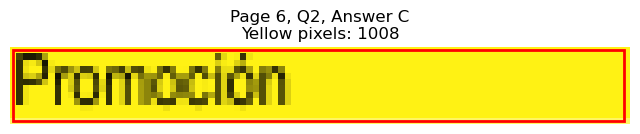

Page 6, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=385.7, y1=190.5
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 292
Page 6, Q2, D: Yellow percentage: 0.0%


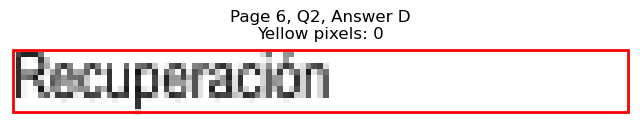


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=181.3, y1=266.2
Page 6, Q3, A: Yellow pixels: 164
Page 6, Q3, A: Total non-white pixels: 744
Page 6, Q3, A: Yellow percentage: 22.0%


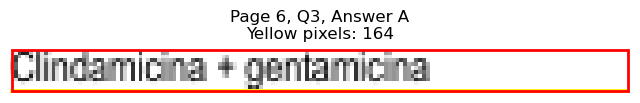

Page 6, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=230.3, y1=278.8
Page 6, Q3, B: Yellow pixels: 1965
Page 6, Q3, B: Total non-white pixels: 2556
Page 6, Q3, B: Yellow percentage: 76.9%


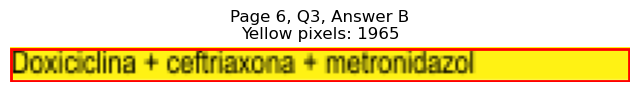

Page 6, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=431.5, y1=266.2
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 504
Page 6, Q3, C: Yellow percentage: 0.0%


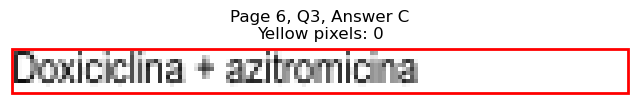

Page 6, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=487.0, y1=278.8
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 761
Page 6, Q3, D: Yellow percentage: 0.0%


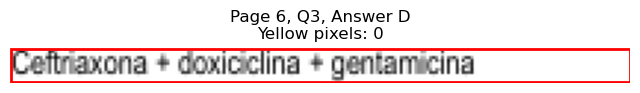


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=107.9, y1=342.0
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 279
Page 6, Q4, A: Yellow percentage: 0.0%


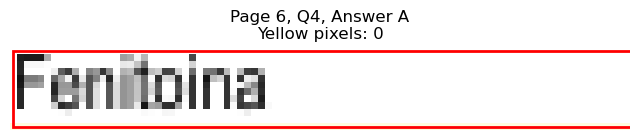

Page 6, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=156.1, y1=354.7
Page 6, Q4, B: Yellow pixels: 1319
Page 6, Q4, B: Total non-white pixels: 1668
Page 6, Q4, B: Yellow percentage: 79.1%


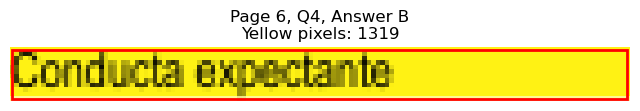

Page 6, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=380.2, y1=342.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 282
Page 6, Q4, C: Yellow percentage: 0.0%


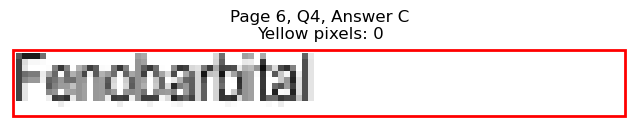

Page 6, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=405.2, y1=354.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 380
Page 6, Q4, D: Yellow percentage: 0.0%


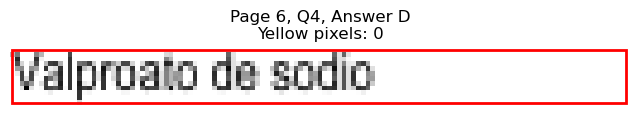


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=173.2, y1=417.7
Page 6, Q5, A: Yellow pixels: 156
Page 6, Q5, A: Total non-white pixels: 701
Page 6, Q5, A: Yellow percentage: 22.3%


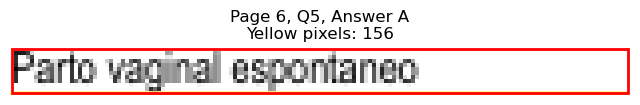

Page 6, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=156.0, y1=430.4
Page 6, Q5, B: Yellow pixels: 1170
Page 6, Q5, B: Total non-white pixels: 1656
Page 6, Q5, B: Yellow percentage: 70.7%


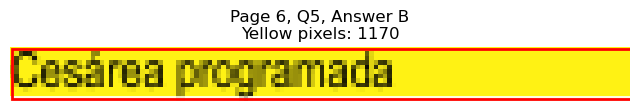

Page 6, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=441.8, y1=417.7
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 578
Page 6, Q5, C: Yellow percentage: 0.0%


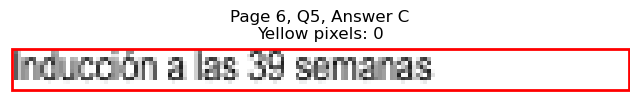

Page 6, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=411.2, y1=430.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 404
Page 6, Q5, D: Yellow percentage: 0.0%


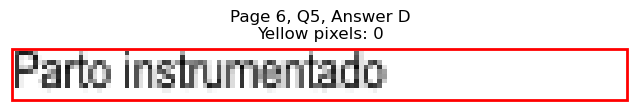


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=372.1, y1=493.5
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 1588
Page 6, Q6, A: Yellow percentage: 0.0%


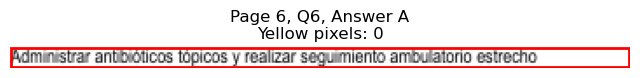

Page 6, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=373.7, y1=506.1
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 1524
Page 6, Q6, B: Yellow percentage: 0.0%


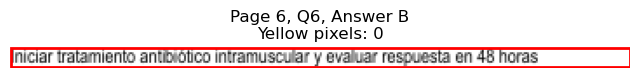

Page 6, Q6 - C: Detected box: x0=68.8, y0=507.7, x1=356.6, y1=518.7
Page 6, Q6, C: Yellow pixels: 339
Page 6, Q6, C: Total non-white pixels: 1805
Page 6, Q6, C: Yellow percentage: 18.8%


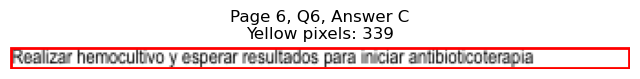

Page 6, Q6 - D: Detected box: x0=68.8, y0=520.3, x1=415.3, y1=531.3
Page 6, Q6, D: Yellow pixels: 3048
Page 6, Q6, D: Total non-white pixels: 4776
Page 6, Q6, D: Yellow percentage: 63.8%


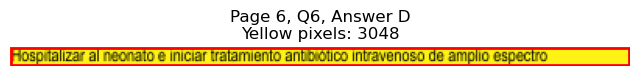


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=596.0, x1=360.1, y1=607.0
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 1552
Page 6, Q7, A: Yellow percentage: 0.0%


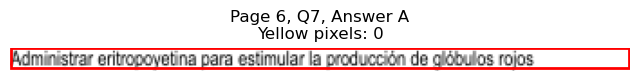

Page 6, Q7 - B: Detected box: x0=68.3, y0=608.6, x1=415.3, y1=619.6
Page 6, Q7, B: Yellow pixels: 398
Page 6, Q7, B: Total non-white pixels: 2088
Page 6, Q7, B: Yellow percentage: 19.1%


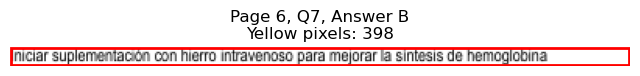

Page 6, Q7 - C: Detected box: x0=68.8, y0=621.3, x1=349.7, y1=632.4
Page 6, Q7, C: Yellow pixels: 2602
Page 6, Q7, C: Total non-white pixels: 3984
Page 6, Q7, C: Yellow percentage: 65.3%


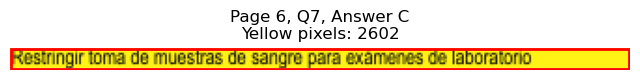

Page 6, Q7 - D: Detected box: x0=68.8, y0=633.9, x1=356.6, y1=645.0
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 1411
Page 6, Q7, D: Yellow percentage: 0.0%


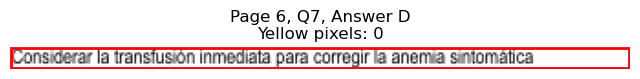


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=709.6, x1=184.7, y1=720.7
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 577
Page 6, Q8, A: Yellow percentage: 0.0%


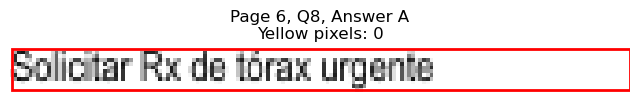

Page 6, Q8 - B: Detected box: x0=68.3, y0=722.2, x1=206.6, y1=733.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 735
Page 6, Q8, B: Yellow percentage: 0.0%


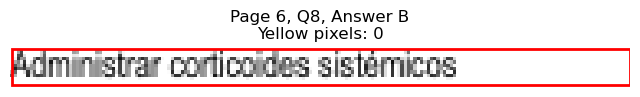

Page 6, Q8 - C: Detected box: x0=327.5, y0=709.6, x1=449.9, y1=720.7
Page 6, Q8, C: Yellow pixels: 1585
Page 6, Q8, C: Total non-white pixels: 2076
Page 6, Q8, C: Yellow percentage: 76.3%


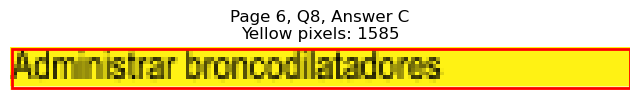

Page 6, Q8 - D: Detected box: x0=327.5, y0=722.2, x1=441.4, y1=733.3
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 608
Page 6, Q8, D: Yellow percentage: 0.0%


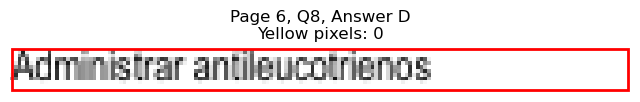


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=183.6, y1=127.4
Page 7, Q1, A: Yellow pixels: 1371
Page 7, Q1, A: Total non-white pixels: 1992
Page 7, Q1, A: Yellow percentage: 68.8%


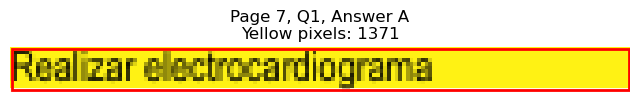

Page 7, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=182.2, y1=140.0
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 606
Page 7, Q1, B: Yellow percentage: 0.0%


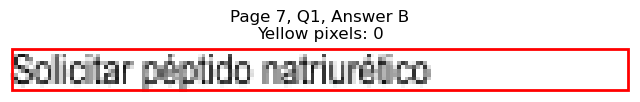

Page 7, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=418.7, y1=127.4
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 450
Page 7, Q1, C: Yellow percentage: 0.0%


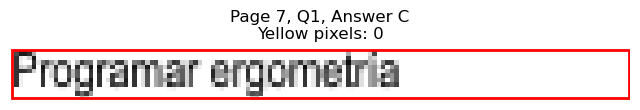

Page 7, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=402.7, y1=140.0
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 393
Page 7, Q1, D: Yellow percentage: 0.0%


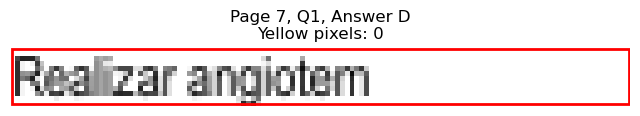


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=194.6, y1=190.5
Page 7, Q2, A: Yellow pixels: 1428
Page 7, Q2, A: Total non-white pixels: 2124
Page 7, Q2, A: Yellow percentage: 67.2%


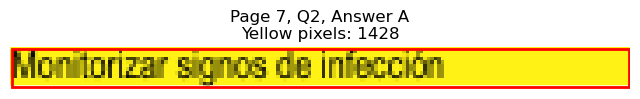

Page 7, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=167.5, y1=203.1
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 546
Page 7, Q2, B: Yellow percentage: 0.0%


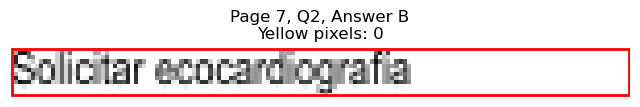

Page 7, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=393.1, y1=190.5
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 313
Page 7, Q2, C: Yellow percentage: 0.0%


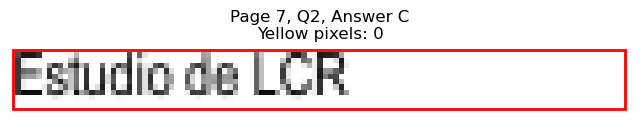

Page 7, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=480.5, y1=203.1
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 813
Page 7, Q2, D: Yellow percentage: 0.0%


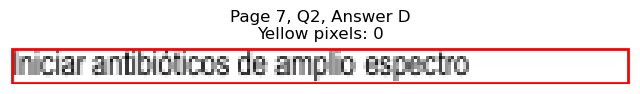


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=144.6, y1=266.2
Page 7, Q3, A: Yellow pixels: 1108
Page 7, Q3, A: Total non-white pixels: 1397
Page 7, Q3, A: Yellow percentage: 79.3%


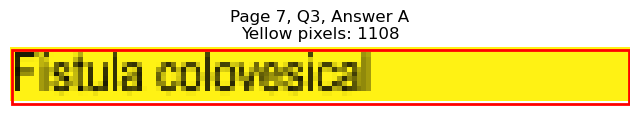

Page 7, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=136.0, y1=278.8
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 343
Page 7, Q3, B: Yellow percentage: 0.0%


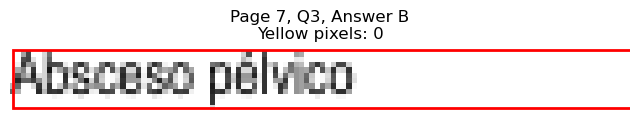

Page 7, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=413.8, y1=266.2
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 434
Page 7, Q3, C: Yellow percentage: 0.0%


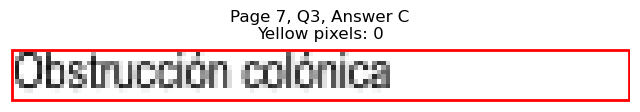

Page 7, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=398.8, y1=278.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 366
Page 7, Q3, D: Yellow percentage: 0.0%


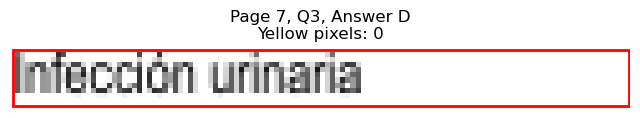


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=115.4, y1=342.0
Page 7, Q4, A: Yellow pixels: 996
Page 7, Q4, A: Total non-white pixels: 1176
Page 7, Q4, A: Yellow percentage: 84.7%


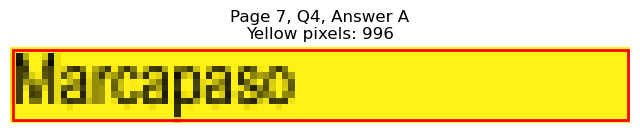

Page 7, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=110.9, y1=354.7
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 202
Page 7, Q4, B: Yellow percentage: 0.0%


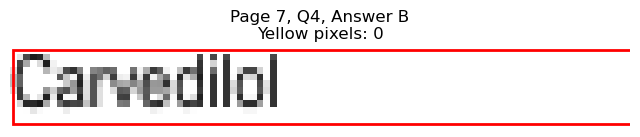

Page 7, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=363.6, y1=342.0
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 192
Page 7, Q4, C: Yellow percentage: 0.0%


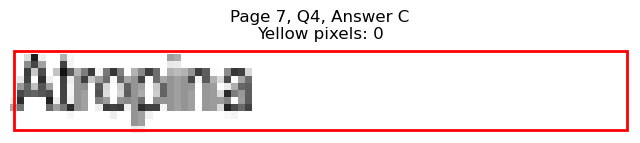

Page 7, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=364.6, y1=354.7
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 185
Page 7, Q4, D: Yellow percentage: 0.0%


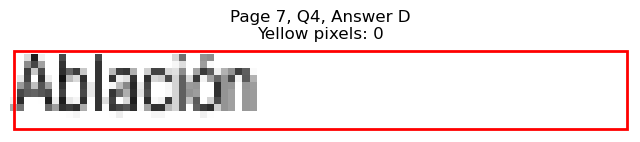


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=155.5, y1=417.7
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 436
Page 7, Q5, A: Yellow percentage: 0.0%


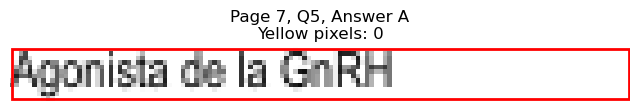

Page 7, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=168.1, y1=430.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 503
Page 7, Q5, B: Yellow percentage: 0.0%


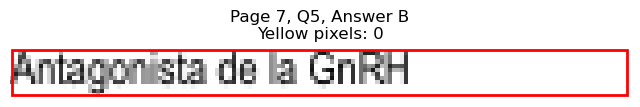

Page 7, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=444.4, y1=417.7
Page 7, Q5, C: Yellow pixels: 1588
Page 7, Q5, C: Total non-white pixels: 2016
Page 7, Q5, C: Yellow percentage: 78.8%


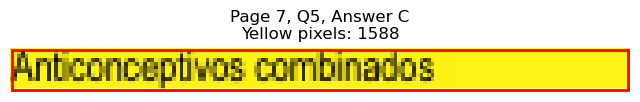

Page 7, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=384.1, y1=430.4
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 287
Page 7, Q5, D: Yellow percentage: 0.0%


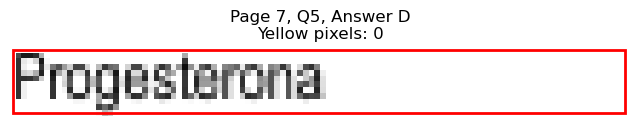


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=495.1, x1=383.6, y1=506.1
Page 7, Q6, A: Yellow pixels: 2816
Page 7, Q6, A: Total non-white pixels: 4038
Page 7, Q6, A: Yellow percentage: 69.7%


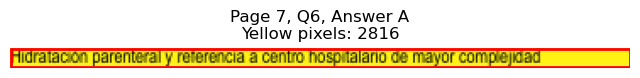

Page 7, Q6 - B: Detected box: x0=68.3, y0=507.7, x1=323.0, y1=518.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 1228
Page 7, Q6, B: Yellow percentage: 0.0%


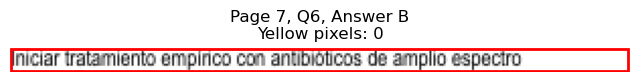

Page 7, Q6 - C: Detected box: x0=68.8, y0=520.3, x1=407.3, y1=531.3
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 1662
Page 7, Q6, C: Yellow percentage: 0.0%


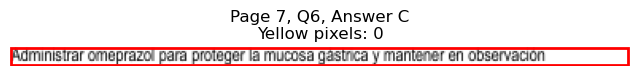

Page 7, Q6 - D: Detected box: x0=68.8, y0=532.9, x1=360.2, y1=543.9
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 1452
Page 7, Q6, D: Yellow percentage: 0.0%


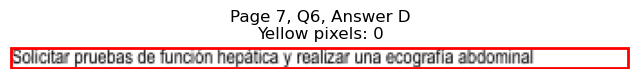


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=226.2, y1=581.8
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 796
Page 7, Q7, A: Yellow percentage: 0.0%


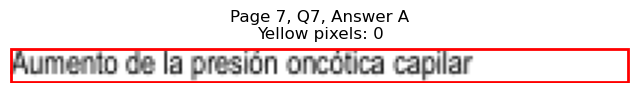

Page 7, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=284.4, y1=594.4
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 1093
Page 7, Q7, B: Yellow percentage: 0.0%


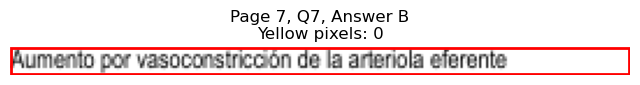

Page 7, Q7 - C: Detected box: x0=68.8, y0=596.0, x1=293.5, y1=607.0
Page 7, Q7, C: Yellow pixels: 276
Page 7, Q7, C: Total non-white pixels: 1678
Page 7, Q7, C: Yellow percentage: 16.4%


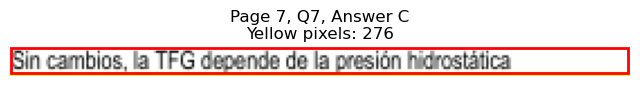

Page 7, Q7 - D: Detected box: x0=68.8, y0=608.6, x1=288.4, y1=619.6
Page 7, Q7, D: Yellow pixels: 2397
Page 7, Q7, D: Total non-white pixels: 3252
Page 7, Q7, D: Yellow percentage: 73.7%


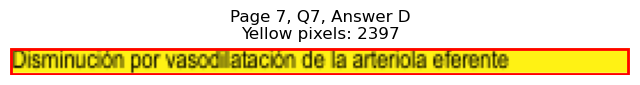


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=234.4, y1=670.2
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 805
Page 7, Q8, A: Yellow percentage: 0.0%


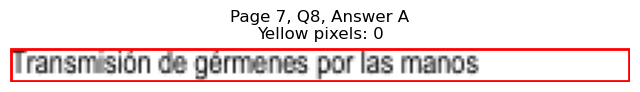

Page 7, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=402.1, y1=682.8
Page 7, Q8, B: Yellow pixels: 385
Page 7, Q8, B: Total non-white pixels: 2070
Page 7, Q8, B: Yellow percentage: 18.6%


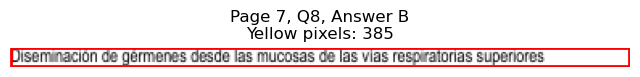

Page 7, Q8 - C: Detected box: x0=68.8, y0=684.3, x1=124.0, y1=695.4
Page 7, Q8, C: Yellow pixels: 963
Page 7, Q8, C: Total non-white pixels: 1272
Page 7, Q8, C: Yellow percentage: 75.7%


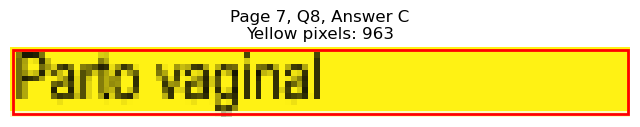

Page 7, Q8 - D: Detected box: x0=68.8, y0=697.0, x1=310.4, y1=708.1
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 1195
Page 7, Q8, D: Yellow percentage: 0.0%


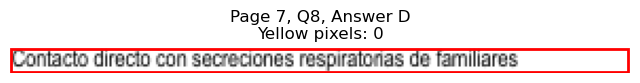


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=747.4, x1=158.2, y1=758.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 464
Page 7, Q9, A: Yellow percentage: 0.0%


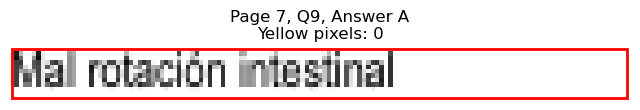

Page 7, Q9 - B: Detected box: x0=68.3, y0=760.2, x1=124.1, y1=771.2
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 250
Page 7, Q9, B: Yellow percentage: 0.0%


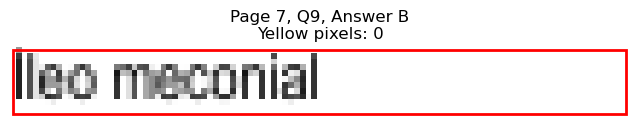

Page 7, Q9 - C: Detected box: x0=327.5, y0=747.4, x1=397.7, y1=758.5
Page 7, Q9, C: Yellow pixels: 121
Page 7, Q9, C: Total non-white pixels: 497
Page 7, Q9, C: Yellow percentage: 24.3%


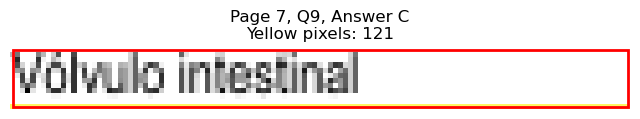

Page 7, Q9 - D: Detected box: x0=327.5, y0=760.2, x1=397.7, y1=771.2
Page 7, Q9, D: Yellow pixels: 1045
Page 7, Q9, D: Total non-white pixels: 1331
Page 7, Q9, D: Yellow percentage: 78.5%


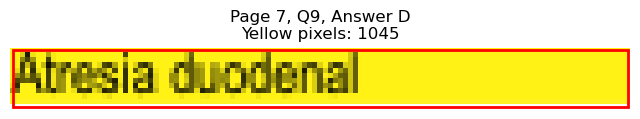


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=89.4, y1=127.4
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 99
Page 8, Q1, A: Yellow percentage: 0.0%


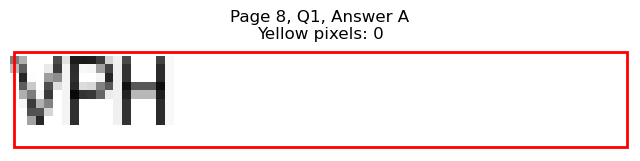

Page 8, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=104.4, y1=140.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 198
Page 8, Q1, B: Yellow percentage: 0.0%


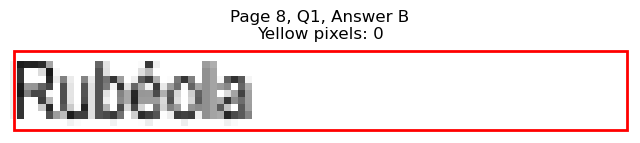

Page 8, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=350.5, y1=127.4
Page 8, Q1, C: Yellow pixels: 723
Page 8, Q1, C: Total non-white pixels: 888
Page 8, Q1, C: Yellow percentage: 81.4%


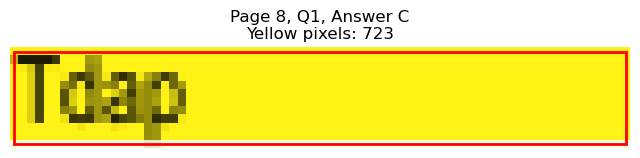

Page 8, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=362.6, y1=140.0
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 170
Page 8, Q1, D: Yellow percentage: 0.0%


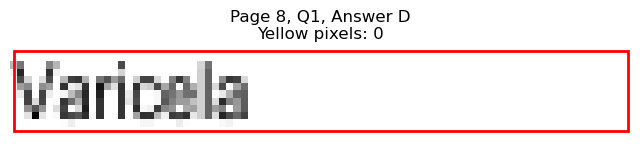


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=175.1, y1=203.1
Page 8, Q2, A: Yellow pixels: 1334
Page 8, Q2, A: Total non-white pixels: 1742
Page 8, Q2, A: Yellow percentage: 76.6%


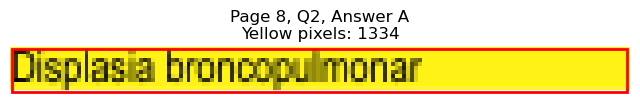

Page 8, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=178.6, y1=215.7
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 579
Page 8, Q2, B: Yellow percentage: 0.0%


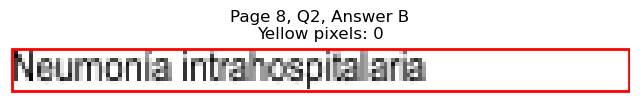

Page 8, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=454.9, y1=203.1
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 638
Page 8, Q2, C: Yellow percentage: 0.0%


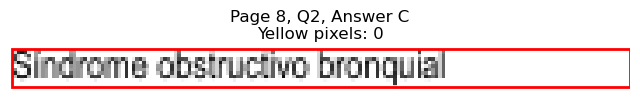

Page 8, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=423.7, y1=215.7
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 507
Page 8, Q2, D: Yellow percentage: 0.0%


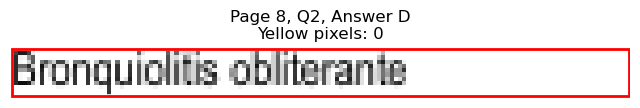


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=113.9, y1=278.8
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 315
Page 8, Q3, A: Yellow percentage: 0.0%


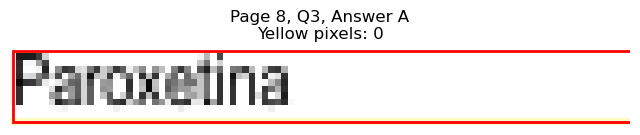

Page 8, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=87.4, y1=291.6
Page 8, Q3, B: Yellow pixels: 708
Page 8, Q3, B: Total non-white pixels: 840
Page 8, Q3, B: Yellow percentage: 84.3%


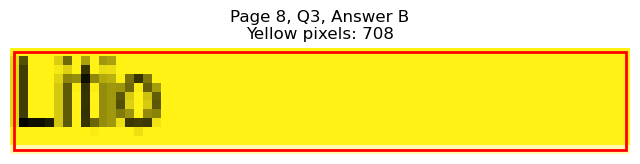

Page 8, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=375.1, y1=278.8
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 227
Page 8, Q3, C: Yellow percentage: 0.0%


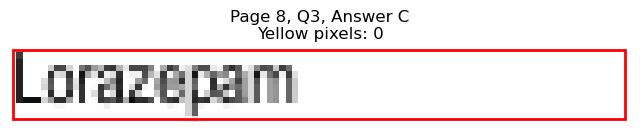

Page 8, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=376.7, y1=291.6
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 271
Page 8, Q3, D: Yellow percentage: 0.0%


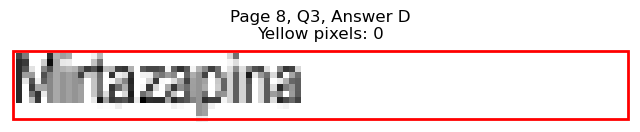


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=233.3, y1=342.0
Page 8, Q4, A: Yellow pixels: 1939
Page 8, Q4, A: Total non-white pixels: 2568
Page 8, Q4, A: Yellow percentage: 75.5%


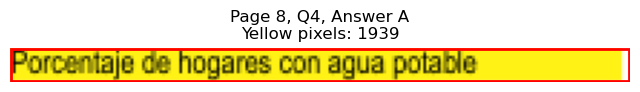

Page 8, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=230.9, y1=354.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 825
Page 8, Q4, B: Yellow percentage: 0.0%


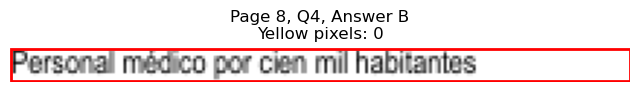

Page 8, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=460.4, y1=342.0
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 675
Page 8, Q4, C: Yellow percentage: 0.0%


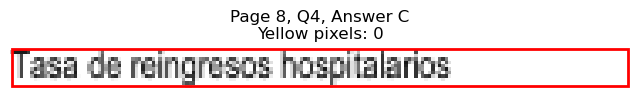

Page 8, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=459.4, y1=354.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 664
Page 8, Q4, D: Yellow percentage: 0.0%


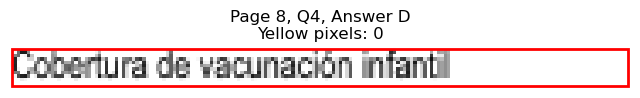


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=237.7, y1=405.1
Page 8, Q5, A: Yellow pixels: 213
Page 8, Q5, A: Total non-white pixels: 1237
Page 8, Q5, A: Yellow percentage: 17.2%


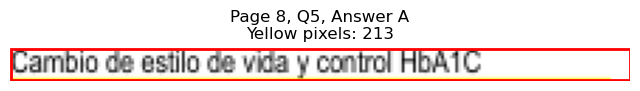

Page 8, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=155.5, y1=417.7
Page 8, Q5, B: Yellow pixels: 1314
Page 8, Q5, B: Total non-white pixels: 1656
Page 8, Q5, B: Yellow percentage: 79.3%


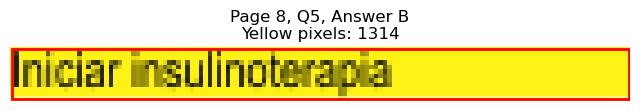

Page 8, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=407.3, y1=405.1
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 430
Page 8, Q5, C: Yellow percentage: 0.0%


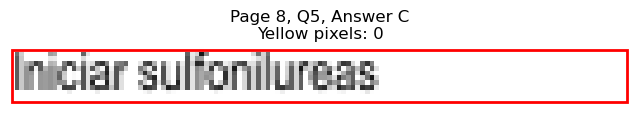

Page 8, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=515.0, y1=417.7
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 917
Page 8, Q5, D: Yellow percentage: 0.0%


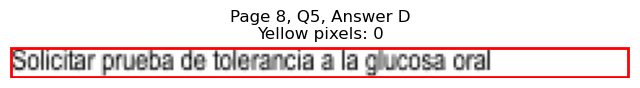


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=239.8, y1=455.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 864
Page 8, Q6, A: Yellow percentage: 0.0%


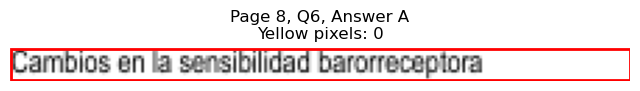

Page 8, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=303.5, y1=468.2
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 1233
Page 8, Q6, B: Yellow percentage: 0.0%


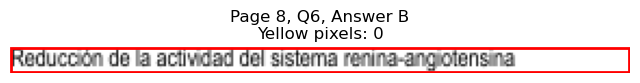

Page 8, Q6 - C: Detected box: x0=68.8, y0=469.8, x1=250.8, y1=480.8
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 1136
Page 8, Q6, C: Yellow percentage: 0.0%


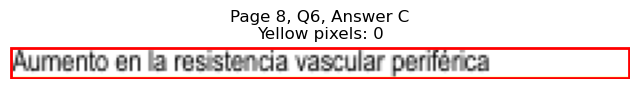

Page 8, Q6 - D: Detected box: x0=68.8, y0=482.5, x1=239.3, y1=493.5
Page 8, Q6, D: Yellow pixels: 1777
Page 8, Q6, D: Total non-white pixels: 2664
Page 8, Q6, D: Yellow percentage: 66.7%


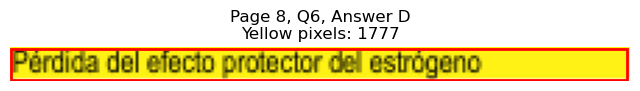


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=195.7, y1=556.5
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 667
Page 8, Q7, A: Yellow percentage: 0.0%


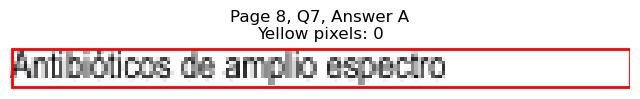

Page 8, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=162.6, y1=569.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 467
Page 8, Q7, B: Yellow percentage: 0.0%


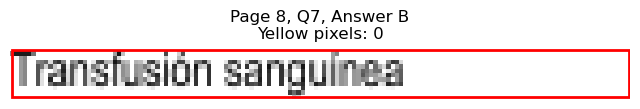

Page 8, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=409.3, y1=556.5
Page 8, Q7, C: Yellow pixels: 133
Page 8, Q7, C: Total non-white pixels: 565
Page 8, Q7, C: Yellow percentage: 23.5%


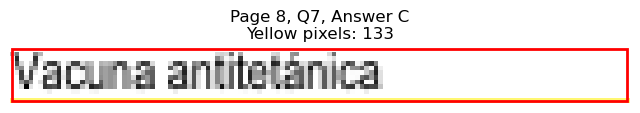

Page 8, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=433.0, y1=569.2
Page 8, Q7, D: Yellow pixels: 1330
Page 8, Q7, D: Total non-white pixels: 1721
Page 8, Q7, D: Yellow percentage: 77.3%


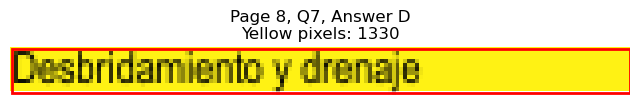


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=102.4, y1=645.0
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 182
Page 8, Q8, A: Yellow percentage: 0.0%


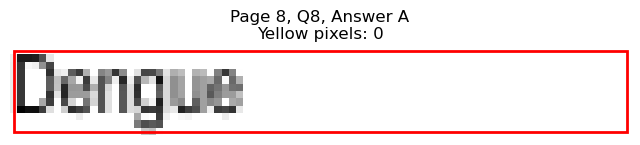

Page 8, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=112.9, y1=657.6
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 225
Page 8, Q8, B: Yellow percentage: 0.0%


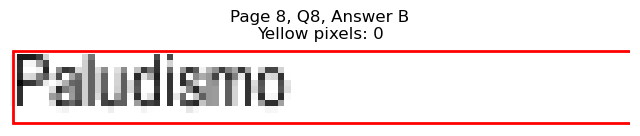

Page 8, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=371.6, y1=645.0
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 317
Page 8, Q8, C: Yellow percentage: 0.0%


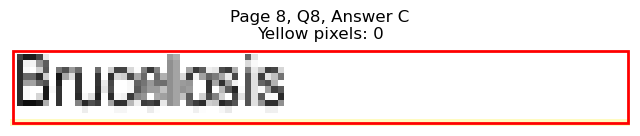

Page 8, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=387.1, y1=657.6
Page 8, Q8, D: Yellow pixels: 972
Page 8, Q8, D: Total non-white pixels: 1332
Page 8, Q8, D: Yellow percentage: 73.0%


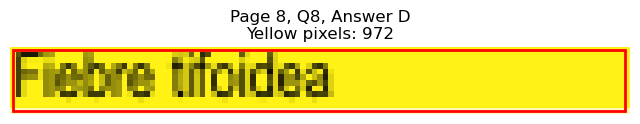


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=164.0, y1=720.7
Page 8, Q9, A: Yellow pixels: 147
Page 8, Q9, A: Total non-white pixels: 674
Page 8, Q9, A: Yellow percentage: 21.8%


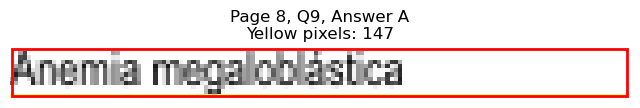

Page 8, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=148.6, y1=733.3
Page 8, Q9, B: Yellow pixels: 1142
Page 8, Q9, B: Total non-white pixels: 1572
Page 8, Q9, B: Yellow percentage: 72.6%


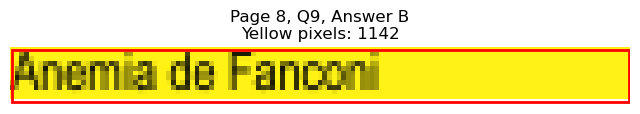

Page 8, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=472.4, y1=720.7
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 716
Page 8, Q9, C: Yellow percentage: 0.0%


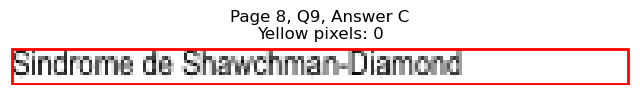

Page 8, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=413.3, y1=733.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 438
Page 8, Q9, D: Yellow percentage: 0.0%


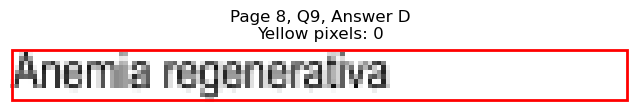


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=133.4, y1=140.0
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 314
Page 9, Q1, A: Yellow percentage: 0.0%


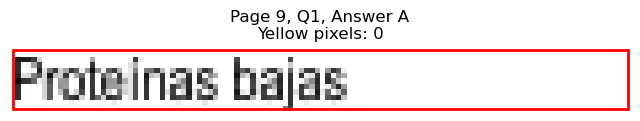

Page 9, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=121.0, y1=152.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 265
Page 9, Q1, B: Yellow percentage: 0.0%


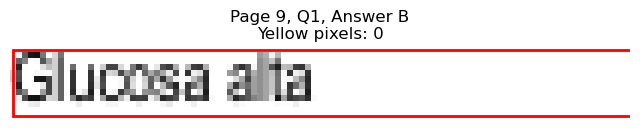

Page 9, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=382.2, y1=140.0
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 366
Page 9, Q1, C: Yellow percentage: 0.0%


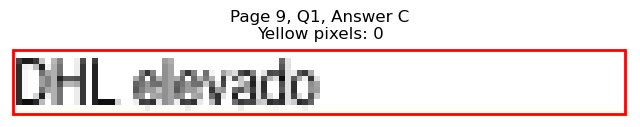

Page 9, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=414.2, y1=152.7
Page 9, Q1, D: Yellow pixels: 1349
Page 9, Q1, D: Total non-white pixels: 1656
Page 9, Q1, D: Yellow percentage: 81.5%


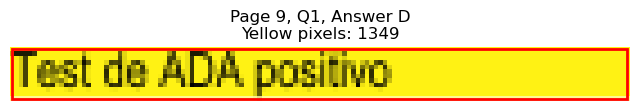


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=218.3, y1=203.1
Page 9, Q2, A: Yellow pixels: 1658
Page 9, Q2, A: Total non-white pixels: 2211
Page 9, Q2, A: Yellow percentage: 75.0%


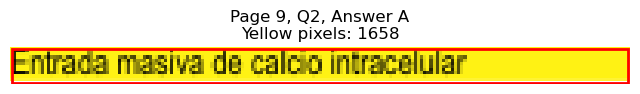

Page 9, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=195.1, y1=215.7
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 642
Page 9, Q2, B: Yellow percentage: 0.0%


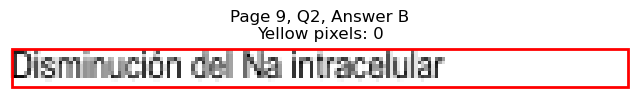

Page 9, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=451.3, y1=203.1
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 647
Page 9, Q2, C: Yellow percentage: 0.0%


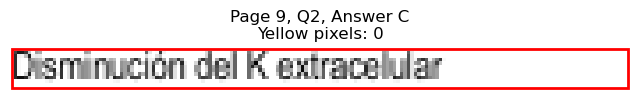

Page 9, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=389.8, y1=215.7
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 581
Page 9, Q2, D: Yellow percentage: 0.0%


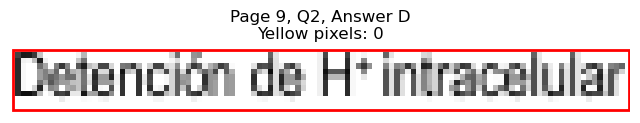


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=105.8, y1=278.8
Page 9, Q3, A: Yellow pixels: 924
Page 9, Q3, A: Total non-white pixels: 1056
Page 9, Q3, A: Yellow percentage: 87.5%


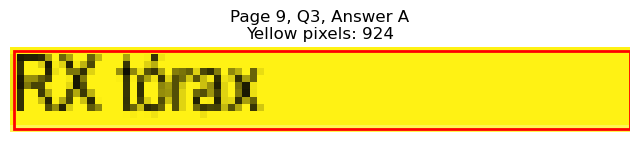

Page 9, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=140.5, y1=291.6
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 352
Page 9, Q3, B: Yellow percentage: 0.0%


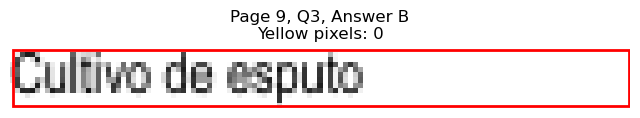

Page 9, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=413.3, y1=278.8
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 445
Page 9, Q3, C: Yellow percentage: 0.0%


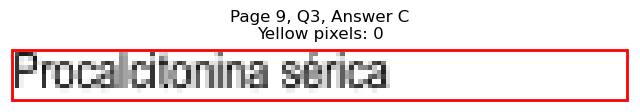

Page 9, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=421.3, y1=291.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 424
Page 9, Q3, D: Yellow percentage: 0.0%


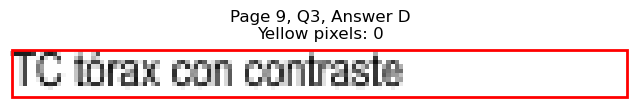


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=169.1, y1=342.0
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 672
Page 9, Q4, A: Yellow percentage: 0.0%


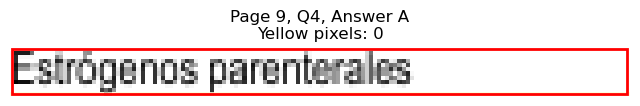

Page 9, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=183.6, y1=354.7
Page 9, Q4, B: Yellow pixels: 1461
Page 9, Q4, B: Total non-white pixels: 1992
Page 9, Q4, B: Yellow percentage: 73.3%


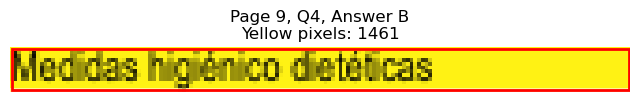

Page 9, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=407.8, y1=342.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 391
Page 9, Q4, C: Yellow percentage: 0.0%


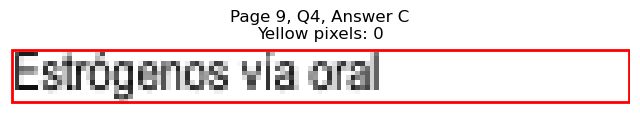

Page 9, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=446.4, y1=354.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 617
Page 9, Q4, D: Yellow percentage: 0.0%


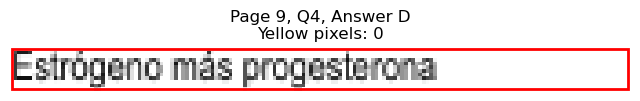


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=118.9, y1=405.1
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 286
Page 9, Q5, A: Yellow percentage: 0.0%


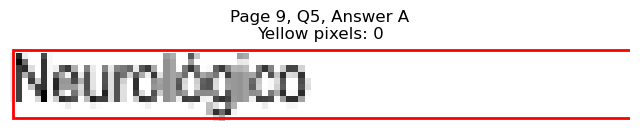

Page 9, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=135.0, y1=417.7
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 311
Page 9, Q5, B: Yellow percentage: 0.0%


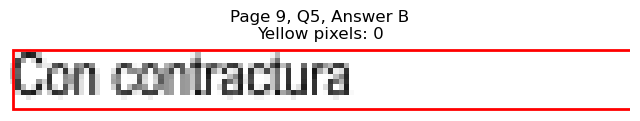

Page 9, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=361.1, y1=405.1
Page 9, Q5, C: Yellow pixels: 801
Page 9, Q5, C: Total non-white pixels: 935
Page 9, Q5, C: Yellow percentage: 85.7%


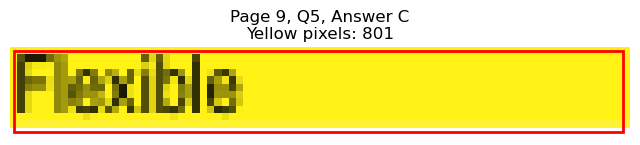

Page 9, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=397.7, y1=417.7
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 373
Page 9, Q5, D: Yellow percentage: 0.0%


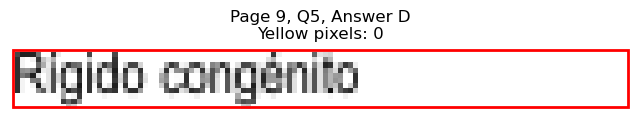


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=107.4, y1=480.8
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 212
Page 9, Q6, A: Yellow percentage: 0.0%


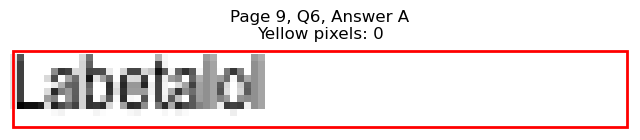

Page 9, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=162.6, y1=493.5
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 489
Page 9, Q6, B: Yellow percentage: 0.0%


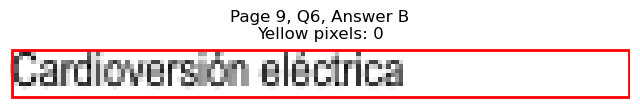

Page 9, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=378.6, y1=480.8
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 362
Page 9, Q6, C: Yellow percentage: 0.0%


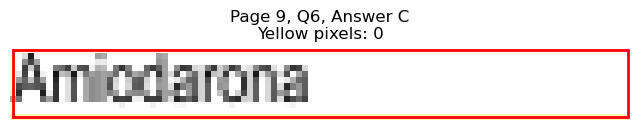

Page 9, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=372.6, y1=493.5
Page 9, Q6, D: Yellow pixels: 891
Page 9, Q6, D: Total non-white pixels: 1152
Page 9, Q6, D: Yellow percentage: 77.3%


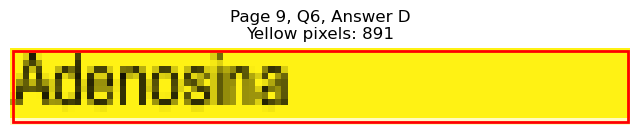


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=169.6, y1=556.5
Page 9, Q7, A: Yellow pixels: 152
Page 9, Q7, A: Total non-white pixels: 660
Page 9, Q7, A: Yellow percentage: 23.0%


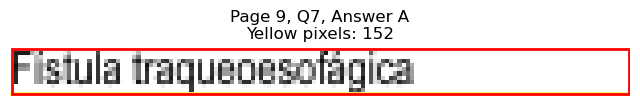

Page 9, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=255.5, y1=569.2
Page 9, Q7, B: Yellow pixels: 1575
Page 9, Q7, B: Total non-white pixels: 2362
Page 9, Q7, B: Yellow percentage: 66.7%


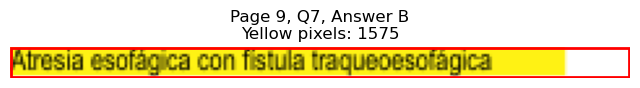

Page 9, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=400.2, y1=556.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 386
Page 9, Q7, C: Yellow percentage: 0.0%


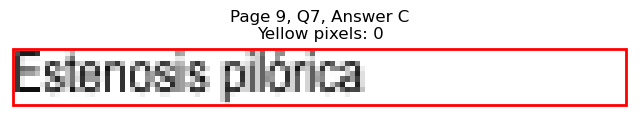

Page 9, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=425.8, y1=569.2
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 478
Page 9, Q7, D: Yellow percentage: 0.0%


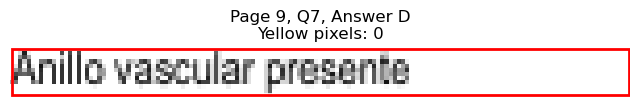


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=621.3, x1=102.8, y1=632.4
Page 9, Q8, A: Yellow pixels: 85
Page 9, Q8, A: Total non-white pixels: 236
Page 9, Q8, A: Yellow percentage: 36.0%


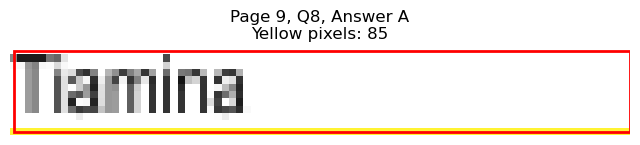

Page 9, Q8 - B: Detected box: x0=68.3, y0=633.9, x1=111.4, y1=645.0
Page 9, Q8, B: Yellow pixels: 978
Page 9, Q8, B: Total non-white pixels: 1128
Page 9, Q8, B: Yellow percentage: 86.7%


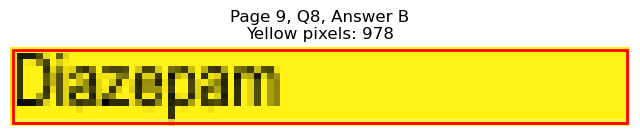

Page 9, Q8 - C: Detected box: x0=327.5, y0=621.3, x1=386.6, y1=632.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 306
Page 9, Q8, C: Yellow percentage: 0.0%


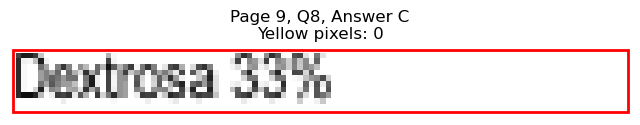

Page 9, Q8 - D: Detected box: x0=327.5, y0=633.9, x1=367.1, y1=645.0
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 200
Page 9, Q8, D: Yellow percentage: 0.0%


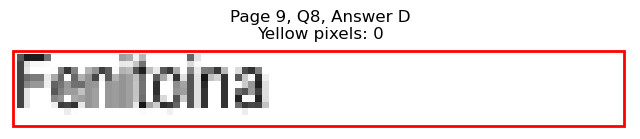


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=684.3, x1=241.2, y1=695.4
Page 9, Q9, A: Yellow pixels: 224
Page 9, Q9, A: Total non-white pixels: 1076
Page 9, Q9, A: Yellow percentage: 20.8%


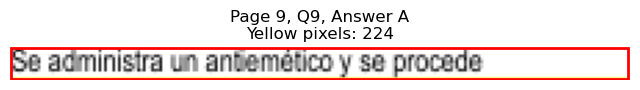

Page 9, Q9 - B: Detected box: x0=68.3, y0=697.0, x1=197.2, y1=708.1
Page 9, Q9, B: Yellow pixels: 1506
Page 9, Q9, B: Total non-white pixels: 1988
Page 9, Q9, B: Yellow percentage: 75.8%


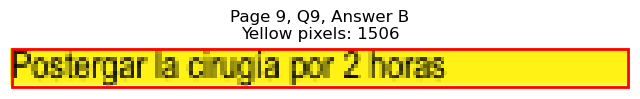

Page 9, Q9 - C: Detected box: x0=68.8, y0=709.6, x1=202.7, y1=720.7
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 626
Page 9, Q9, C: Yellow percentage: 0.0%


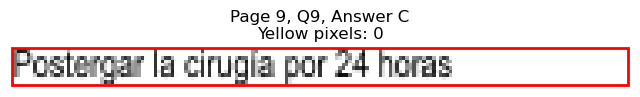

Page 9, Q9 - D: Detected box: x0=68.8, y0=722.2, x1=292.4, y1=733.3
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 1110
Page 9, Q9, D: Yellow percentage: 0.0%


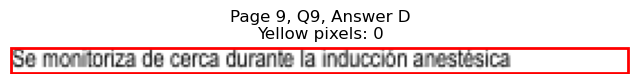


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=127.4, y1=114.8
Page 10, Q1, A: Yellow pixels: 110
Page 10, Q1, A: Total non-white pixels: 423
Page 10, Q1, A: Yellow percentage: 26.0%


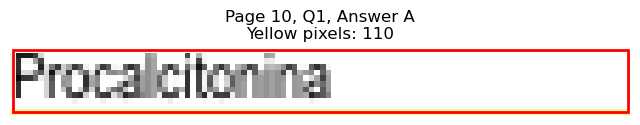

Page 10, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=100.4, y1=127.4
Page 10, Q1, B: Yellow pixels: 799
Page 10, Q1, B: Total non-white pixels: 996
Page 10, Q1, B: Yellow percentage: 80.2%


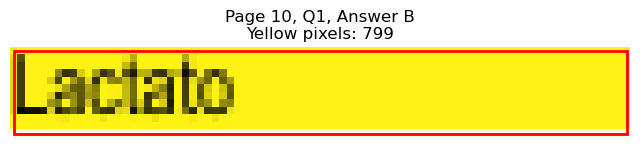

Page 10, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=349.1, y1=114.8
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 103
Page 10, Q1, C: Yellow percentage: 0.0%


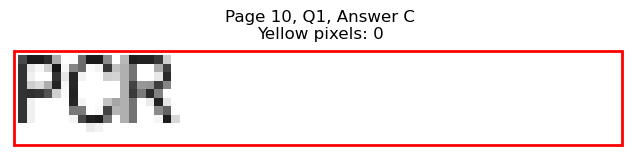

Page 10, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=368.2, y1=127.4
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 187
Page 10, Q1, D: Yellow percentage: 0.0%


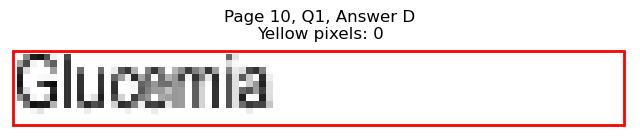


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=210.2, y1=190.5
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 695
Page 10, Q2, A: Yellow percentage: 0.0%


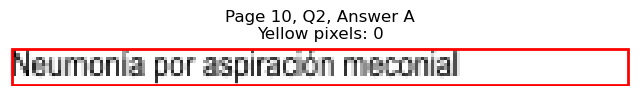

Page 10, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=195.6, y1=203.1
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 638
Page 10, Q2, B: Yellow percentage: 0.0%


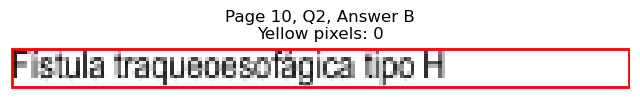

Page 10, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=399.2, y1=190.5
Page 10, Q2, C: Yellow pixels: 1057
Page 10, Q2, C: Total non-white pixels: 1476
Page 10, Q2, C: Yellow percentage: 71.6%


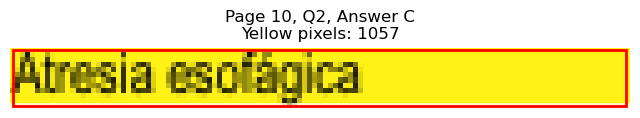

Page 10, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=413.3, y1=203.1
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 479
Page 10, Q2, D: Yellow percentage: 0.0%


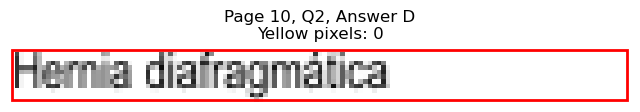


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=124.4, y1=253.6
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 272
Page 10, Q3, A: Yellow percentage: 0.0%


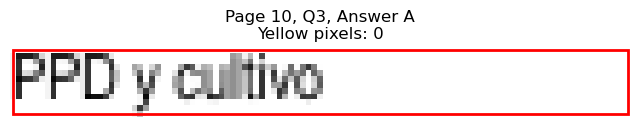

Page 10, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=142.6, y1=266.2
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 352
Page 10, Q3, B: Yellow percentage: 0.0%


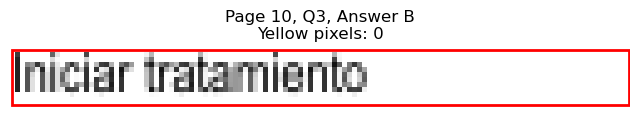

Page 10, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=406.7, y1=253.6
Page 10, Q3, C: Yellow pixels: 130
Page 10, Q3, C: Total non-white pixels: 500
Page 10, Q3, C: Yellow percentage: 26.0%


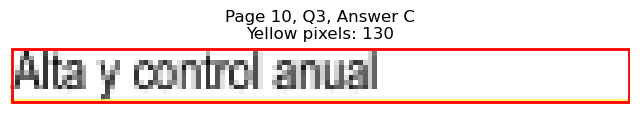

Page 10, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=394.2, y1=266.2
Page 10, Q3, D: Yellow pixels: 1066
Page 10, Q3, D: Total non-white pixels: 1300
Page 10, Q3, D: Yellow percentage: 82.0%


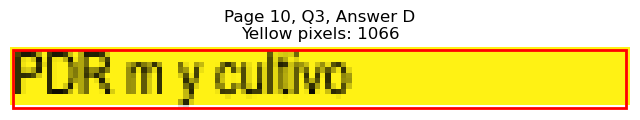


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=113.9, y1=329.4
Page 10, Q4, A: Yellow pixels: 96
Page 10, Q4, A: Total non-white pixels: 339
Page 10, Q4, A: Yellow percentage: 28.3%


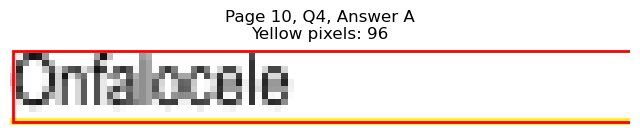

Page 10, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=103.4, y1=342.0
Page 10, Q4, B: Yellow pixels: 881
Page 10, Q4, B: Total non-white pixels: 1032
Page 10, Q4, B: Yellow percentage: 85.4%


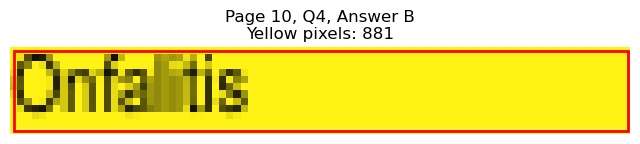

Page 10, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=369.6, y1=329.4
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 209
Page 10, Q4, C: Yellow percentage: 0.0%


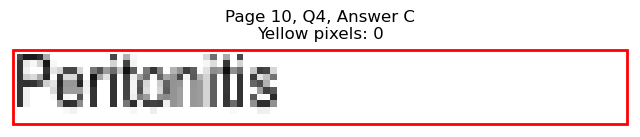

Page 10, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=361.6, y1=342.0
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 188
Page 10, Q4, D: Yellow percentage: 0.0%


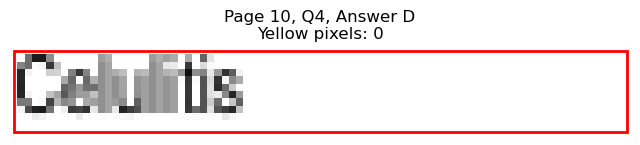


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=139.4, y1=405.1
Page 10, Q5, A: Yellow pixels: 1061
Page 10, Q5, A: Total non-white pixels: 1342
Page 10, Q5, A: Yellow percentage: 79.1%


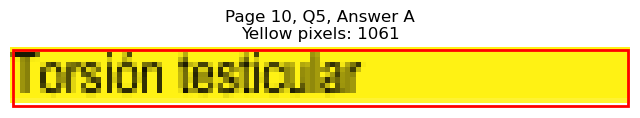

Page 10, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=101.9, y1=417.7
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 170
Page 10, Q5, B: Yellow percentage: 0.0%


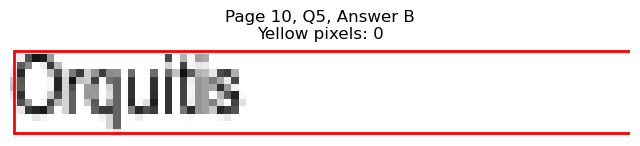

Page 10, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=375.6, y1=405.1
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 249
Page 10, Q5, C: Yellow percentage: 0.0%


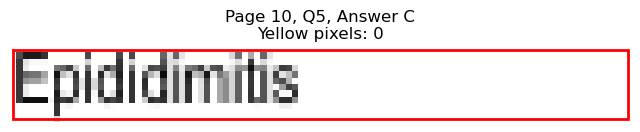

Page 10, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=372.1, y1=417.7
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 219
Page 10, Q5, D: Yellow percentage: 0.0%


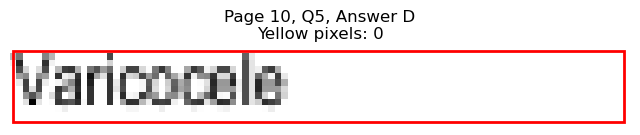


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=257.9, y1=493.5
Page 10, Q6, A: Yellow pixels: 213
Page 10, Q6, A: Total non-white pixels: 1151
Page 10, Q6, A: Yellow percentage: 18.5%


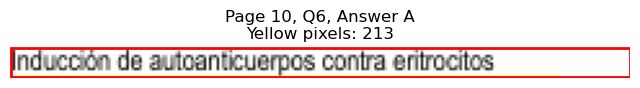

Page 10, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=234.8, y1=506.1
Page 10, Q6, B: Yellow pixels: 1723
Page 10, Q6, B: Total non-white pixels: 2358
Page 10, Q6, B: Yellow percentage: 73.1%


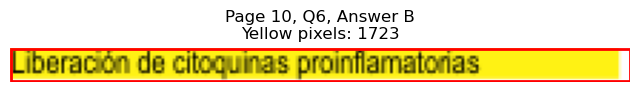

Page 10, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=474.4, y1=493.5
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 744
Page 10, Q6, C: Yellow percentage: 0.0%


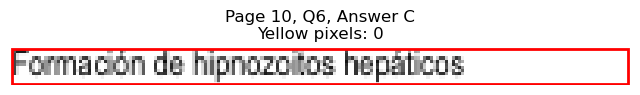

Page 10, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=531.6, y1=506.1
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 1016
Page 10, Q6, D: Yellow percentage: 0.0%


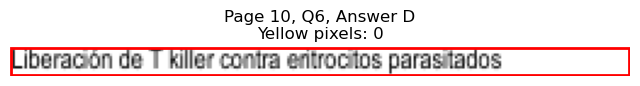


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=115.4, y1=581.8
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 253
Page 10, Q7, A: Yellow percentage: 0.0%


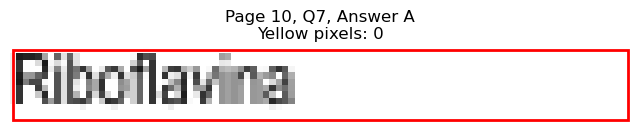

Page 10, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=102.8, y1=594.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 151
Page 10, Q7, B: Yellow percentage: 0.0%


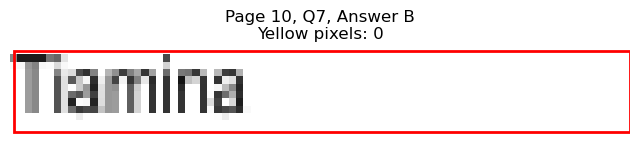

Page 10, Q7 - C: Detected box: x0=327.5, y0=570.8, x1=360.1, y1=581.8
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 250
Page 10, Q7, C: Yellow percentage: 0.0%


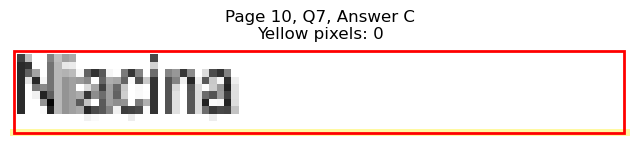

Page 10, Q7 - D: Detected box: x0=327.5, y0=583.4, x1=378.1, y1=594.4
Page 10, Q7, D: Yellow pixels: 915
Page 10, Q7, D: Total non-white pixels: 1224
Page 10, Q7, D: Yellow percentage: 74.8%


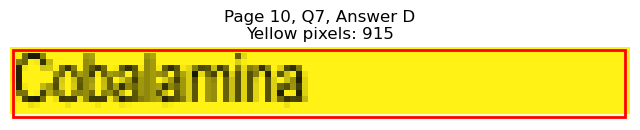


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=191.2, y1=657.6
Page 10, Q8, A: Yellow pixels: 1448
Page 10, Q8, A: Total non-white pixels: 2088
Page 10, Q8, A: Yellow percentage: 69.3%


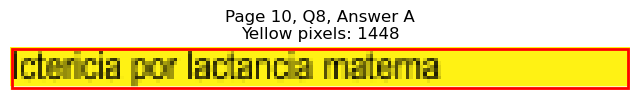

Page 10, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=154.6, y1=670.2
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 451
Page 10, Q8, B: Yellow percentage: 0.0%


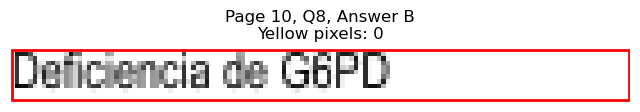

Page 10, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=416.8, y1=657.6
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 493
Page 10, Q8, C: Yellow percentage: 0.0%


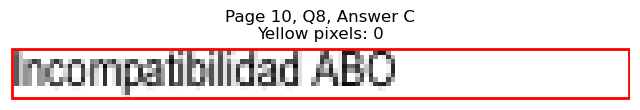

Page 10, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=394.2, y1=670.2
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 347
Page 10, Q8, D: Yellow percentage: 0.0%


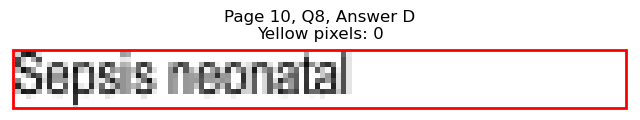


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=56.6, y0=722.2, x1=65.2, y1=733.3
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 60
Page 10, Q9, A: Yellow percentage: 0.0%


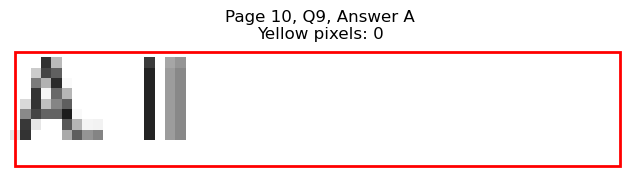

Page 10, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=83.9, y1=745.9
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 52
Page 10, Q9, B: Yellow percentage: 0.0%


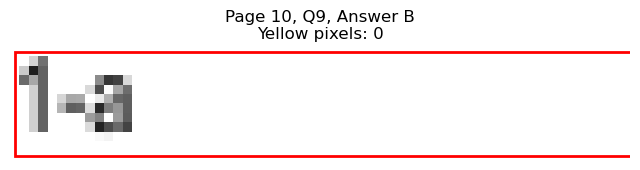

Page 10, Q9 - C: Detected box: x0=327.5, y0=722.2, x1=343.1, y1=733.3
Page 10, Q9, C: Yellow pixels: 67
Page 10, Q9, C: Total non-white pixels: 113
Page 10, Q9, C: Yellow percentage: 59.3%


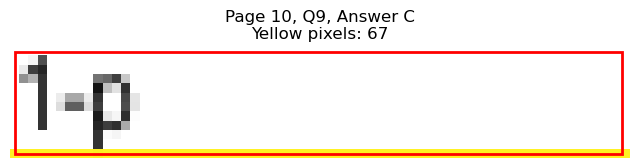

Page 10, Q9 - D: Detected box: x0=315.4, y0=734.8, x1=324.4, y1=745.9
Page 10, Q9, D: Yellow pixels: 678
Page 10, Q9, D: Total non-white pixels: 720
Page 10, Q9, D: Yellow percentage: 94.2%


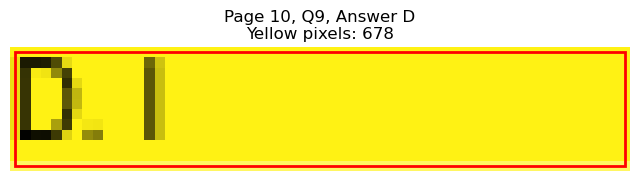


Page 10, Q9 - Selected Answer: D (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=218.6, y1=114.8
Page 11, Q1, A: Yellow pixels: 1825
Page 11, Q1, A: Total non-white pixels: 2412
Page 11, Q1, A: Yellow percentage: 75.7%


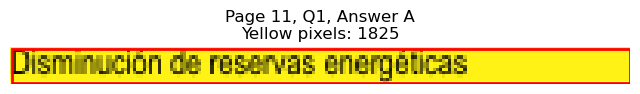

Page 11, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=204.1, y1=127.4
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 727
Page 11, Q1, B: Yellow percentage: 0.0%


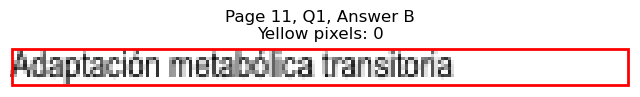

Page 11, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=437.8, y1=114.8
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 604
Page 11, Q1, C: Yellow percentage: 0.0%


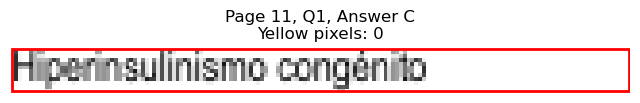

Page 11, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=393.7, y1=127.4
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 355
Page 11, Q1, D: Yellow percentage: 0.0%


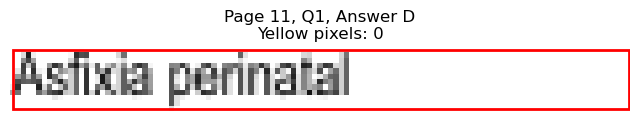


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=136.4, y1=190.5
Page 11, Q2, A: Yellow pixels: 119
Page 11, Q2, A: Total non-white pixels: 437
Page 11, Q2, A: Yellow percentage: 27.2%


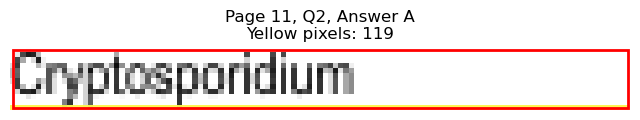

Page 11, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=133.9, y1=203.1
Page 11, Q2, B: Yellow pixels: 1012
Page 11, Q2, B: Total non-white pixels: 1276
Page 11, Q2, B: Yellow percentage: 79.3%


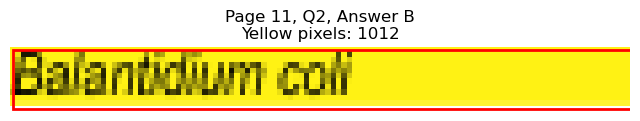

Page 11, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=390.1, y1=190.5
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 327
Page 11, Q2, C: Yellow percentage: 0.0%


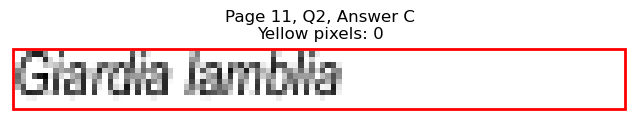

Page 11, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=375.1, y1=203.1
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 244
Page 11, Q2, D: Yellow percentage: 0.0%


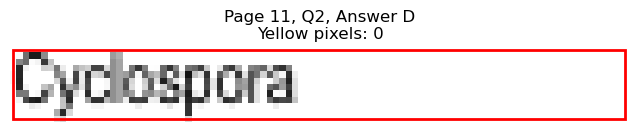


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=149.0, y1=266.2
Page 11, Q3, A: Yellow pixels: 1157
Page 11, Q3, A: Total non-white pixels: 1453
Page 11, Q3, A: Yellow percentage: 79.6%


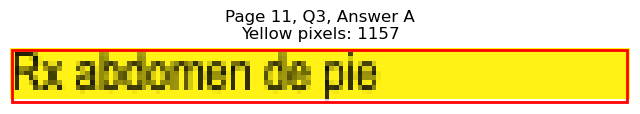

Page 11, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=162.6, y1=278.8
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 468
Page 11, Q3, B: Yellow percentage: 0.0%


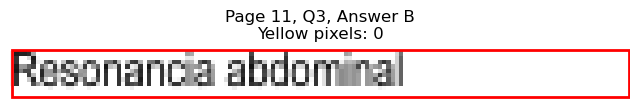

Page 11, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=411.7, y1=266.2
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 406
Page 11, Q3, C: Yellow percentage: 0.0%


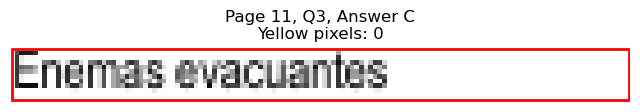

Page 11, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=446.9, y1=278.8
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 650
Page 11, Q3, D: Yellow percentage: 0.0%


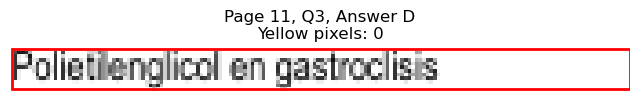


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=359.6, y1=342.0
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 1451
Page 11, Q4, A: Yellow percentage: 0.0%


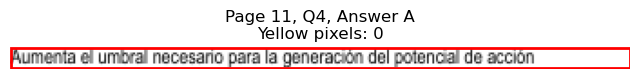

Page 11, Q4 - B: Detected box: x0=68.3, y0=343.8, x1=411.9, y1=354.8
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 2092
Page 11, Q4, B: Yellow percentage: 0.0%


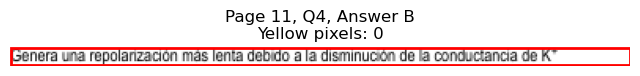

Page 11, Q4 - C: Detected box: x0=68.8, y0=356.5, x1=298.9, y1=367.5
Page 11, Q4, C: Yellow pixels: 2225
Page 11, Q4, C: Total non-white pixels: 3372
Page 11, Q4, C: Yellow percentage: 66.0%


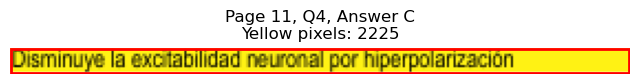

Page 11, Q4 - D: Detected box: x0=68.8, y0=369.1, x1=408.8, y1=380.1
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 1763
Page 11, Q4, D: Yellow percentage: 0.0%


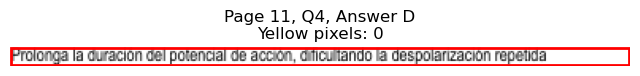


Page 11, Q4 - Selected Answer: C (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=419.6, x1=150.5, y1=430.6
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 417
Page 11, Q5, A: Yellow percentage: 0.0%


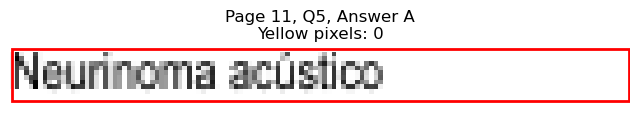

Page 11, Q5 - B: Detected box: x0=68.3, y0=432.2, x1=119.9, y1=443.2
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 292
Page 11, Q5, B: Yellow percentage: 0.0%


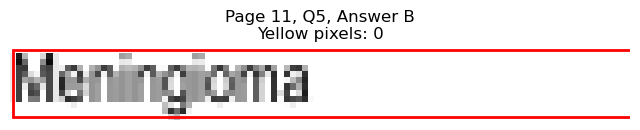

Page 11, Q5 - C: Detected box: x0=327.5, y0=419.6, x1=429.2, y1=430.6
Page 11, Q5, C: Yellow pixels: 153
Page 11, Q5, C: Total non-white pixels: 665
Page 11, Q5, C: Yellow percentage: 23.0%


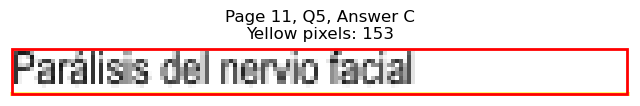

Page 11, Q5 - D: Detected box: x0=327.5, y0=432.2, x1=422.8, y1=443.2
Page 11, Q5, D: Yellow pixels: 1224
Page 11, Q5, D: Total non-white pixels: 1611
Page 11, Q5, D: Yellow percentage: 76.0%


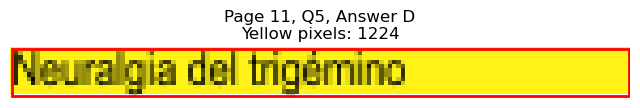


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=495.3, x1=139.0, y1=506.4
Page 11, Q6, A: Yellow pixels: 121
Page 11, Q6, A: Total non-white pixels: 467
Page 11, Q6, A: Yellow percentage: 25.9%


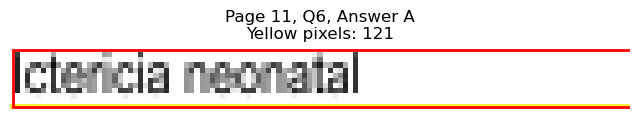

Page 11, Q6 - B: Detected box: x0=68.3, y0=507.9, x1=193.2, y1=519.0
Page 11, Q6, B: Yellow pixels: 1607
Page 11, Q6, B: Total non-white pixels: 2112
Page 11, Q6, B: Yellow percentage: 76.1%


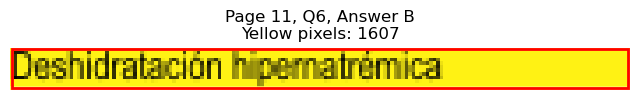

Page 11, Q6 - C: Detected box: x0=327.5, y0=495.3, x1=381.6, y1=506.4
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 310
Page 11, Q6, C: Yellow percentage: 0.0%


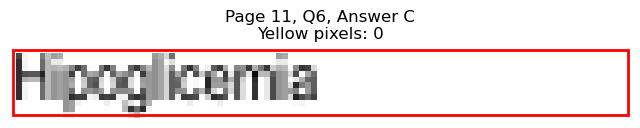

Page 11, Q6 - D: Detected box: x0=327.5, y0=507.9, x1=394.2, y1=519.0
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 347
Page 11, Q6, D: Yellow percentage: 0.0%


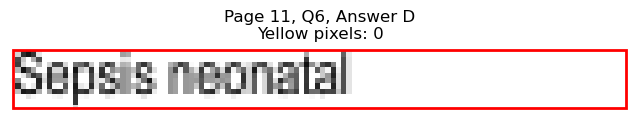


Page 11, Q6 - Selected Answer: B (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=583.6, x1=134.0, y1=594.7
Page 11, Q7, A: Yellow pixels: 1116
Page 11, Q7, A: Total non-white pixels: 1404
Page 11, Q7, A: Yellow percentage: 79.5%


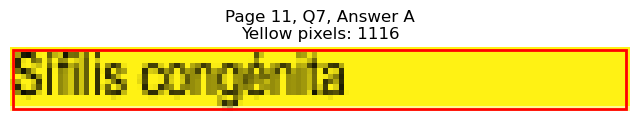

Page 11, Q7 - B: Detected box: x0=68.3, y0=596.2, x1=120.5, y1=607.3
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 268
Page 11, Q7, B: Yellow percentage: 0.0%


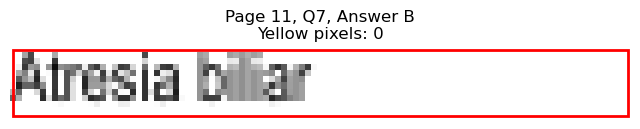

Page 11, Q7 - C: Detected box: x0=327.5, y0=583.6, x1=431.8, y1=594.7
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 552
Page 11, Q7, C: Yellow percentage: 0.0%


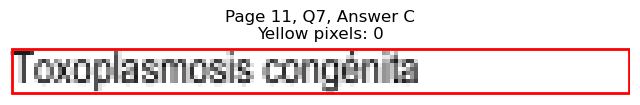

Page 11, Q7 - D: Detected box: x0=327.5, y0=596.2, x1=402.2, y1=607.3
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 364
Page 11, Q7, D: Yellow percentage: 0.0%


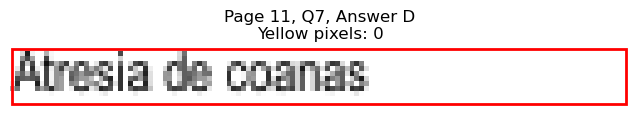


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=68.3, y0=659.4, x1=124.0, y1=670.4
Page 11, Q8, A: Yellow pixels: 959
Page 11, Q8, A: Total non-white pixels: 1272
Page 11, Q8, A: Yellow percentage: 75.4%


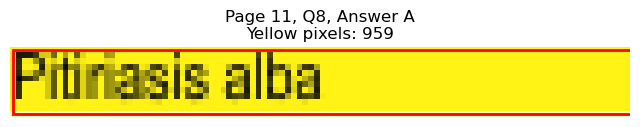

Page 11, Q8 - B: Detected box: x0=68.3, y0=672.1, x1=129.5, y1=683.1
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 302
Page 11, Q8, B: Yellow percentage: 0.0%


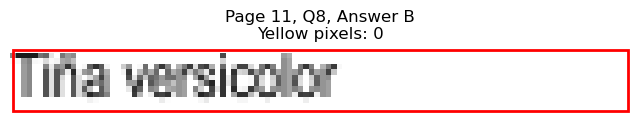

Page 11, Q8 - C: Detected box: x0=327.5, y0=659.4, x1=415.2, y1=670.4
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 458
Page 11, Q8, C: Yellow percentage: 0.0%


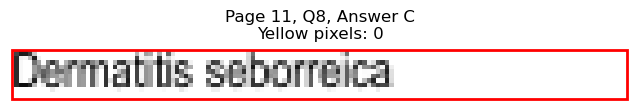

Page 11, Q8 - D: Detected box: x0=327.5, y0=672.1, x1=357.1, y1=683.1
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 147
Page 11, Q8, D: Yellow percentage: 0.0%


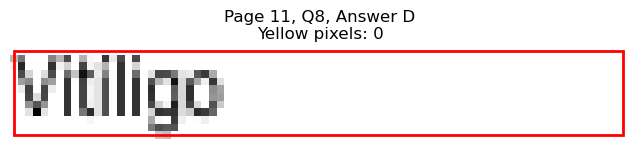


Page 11, Q8 - Selected Answer: A (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=68.3, y0=722.5, x1=147.5, y1=733.5
Page 11, Q9, A: Yellow pixels: 130
Page 11, Q9, A: Total non-white pixels: 499
Page 11, Q9, A: Yellow percentage: 26.1%


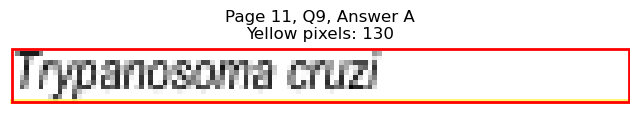

Page 11, Q9 - B: Detected box: x0=68.3, y0=735.2, x1=164.0, y1=746.2
Page 11, Q9, B: Yellow pixels: 1235
Page 11, Q9, B: Total non-white pixels: 1617
Page 11, Q9, B: Yellow percentage: 76.4%


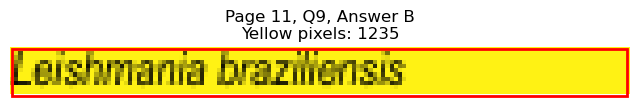

Page 11, Q9 - C: Detected box: x0=327.5, y0=722.5, x1=415.3, y1=733.5
Page 11, Q9, C: Yellow pixels: 0
Page 11, Q9, C: Total non-white pixels: 426
Page 11, Q9, C: Yellow percentage: 0.0%


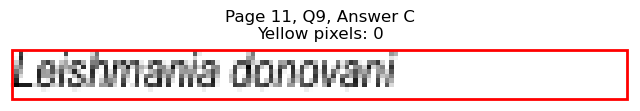

Page 11, Q9 - D: Detected box: x0=327.5, y0=735.2, x1=418.8, y1=746.2
Page 11, Q9, D: Yellow pixels: 0
Page 11, Q9, D: Total non-white pixels: 471
Page 11, Q9, D: Yellow percentage: 0.0%


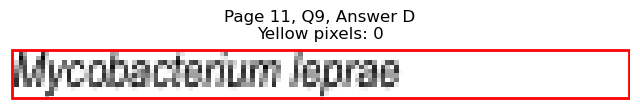


Page 11, Q9 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 2 questions
Page 12, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=162.1, y1=127.4
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 485
Page 12, Q1, A: Yellow percentage: 0.0%


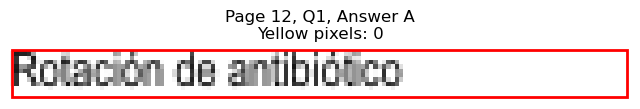

Page 12, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=186.1, y1=140.0
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 581
Page 12, Q1, B: Yellow percentage: 0.0%


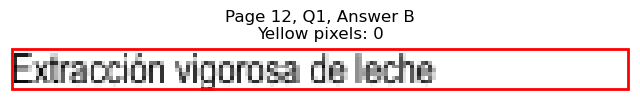

Page 12, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=403.7, y1=127.4
Page 12, Q1, C: Yellow pixels: 1098
Page 12, Q1, C: Total non-white pixels: 1524
Page 12, Q1, C: Yellow percentage: 72.0%


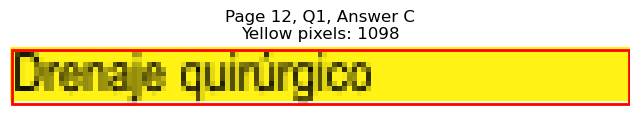

Page 12, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=399.7, y1=140.0
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 362
Page 12, Q1, D: Yellow percentage: 0.0%


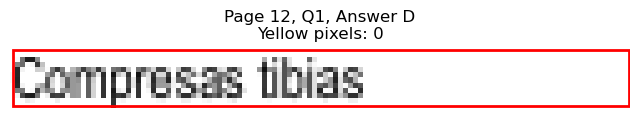


Page 12, Q1 - Selected Answer: C (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=115.9, y1=190.5
Page 12, Q2, A: Yellow pixels: 98
Page 12, Q2, A: Total non-white pixels: 343
Page 12, Q2, A: Yellow percentage: 28.6%


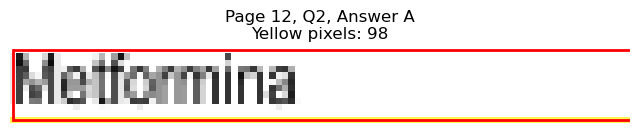

Page 12, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=212.2, y1=203.1
Page 12, Q2, B: Yellow pixels: 1588
Page 12, Q2, B: Total non-white pixels: 2147
Page 12, Q2, B: Yellow percentage: 74.0%


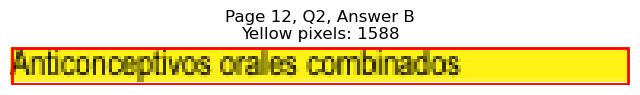

Page 12, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=394.7, y1=190.5
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 361
Page 12, Q2, C: Yellow percentage: 0.0%


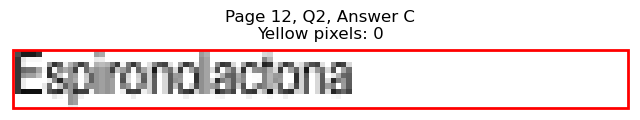

Page 12, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=374.6, y1=203.1
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 262
Page 12, Q2, D: Yellow percentage: 0.0%


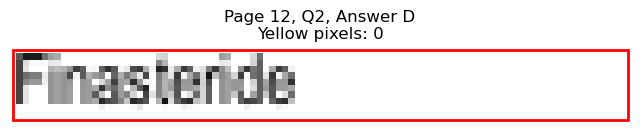


Page 12, Q2 - Selected Answer: B (based on yellow pixel count)






In [14]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [15]:
questions_df

question
0   Varón de 65 años con antecedente de hipertensi...
1   Mujer de 32 años asintomática que acude por ch...
2   ¿Cuál es el sitio más frecuente de implantació...
3   Varón de 43 años, llevado a urgencias porque s...
4   Varón de 27 años, acude a consulta por visión ...
..                                                ...
95  Lactante de 40 días, es referido a Lima, por p...
96  Adolescente de 12 años, traído por madre, quie...
97  Joven procedente de área rural andina presenta...
98  Puérpera mediata de 33 años, acude por present...
99  Mujer de 24 años con presencia de irregularida...

[100 rows x 1 columns]

In [16]:
answers_df

option_A                           option_B  \
0                       Labetalol                        Hidralazina   
1            Solicitar prolactina                         Mamografía   
2                   Fondo uterino        Segmento inferior del útero   
3   Colocación de catéter central            Ventilación no invasiva   
4                              VI                                  I   
..                            ...                                ...   
95              Sífilis congénita                     Atresia biliar   
96                Pitiriasis alba                    Tiña versicolor   
97              Trypanosoma cruzi            Leishmania braziliensis   
98        Rotación de antibiótico       Extracción vigorosa de leche   
99                     Metformina  Anticonceptivos orales combinados   

                      option_C                option_D  
0                Nitroprusiato          Nitroglicerina  
1           Ecografía de mamas             Observación  
2               Cérvix uterino          Cuerno uterino  
3   Fijación costal quirúrgica  Intubación orotraqueal  
4                          III                      IV  
..                         ...                     ...  
95     Toxoplasmosis congénita       Atresia de coanas  
96       Dermatitis seborreica                Vitíligo  
97         Leishmania donovani    Mycobacterium leprae  
98          Drenaje quirúrgico        Compresas tibias  
99             Espironolactona             Finasteride  

[100 rows x 4 columns]

In [17]:
correct_answers_df

correct_answer
0               C
1               D
2               A
3               D
4               C
..            ...
95              A
96              A
97              B
98              C
99              B

[100 rows x 1 columns]

In [18]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 65 años con antecedente de hipertensi...   
1   Mujer de 32 años asintomática que acude por ch...   
2   ¿Cuál es el sitio más frecuente de implantació...   
3   Varón de 43 años, llevado a urgencias porque s...   
4   Varón de 27 años, acude a consulta por visión ...   
..                                                ...   
95  Lactante de 40 días, es referido a Lima, por p...   
96  Adolescente de 12 años, traído por madre, quie...   
97  Joven procedente de área rural andina presenta...   
98  Puérpera mediata de 33 años, acude por present...   
99  Mujer de 24 años con presencia de irregularida...   

                         option_A                           option_B  \
0                       Labetalol                        Hidralazina   
1            Solicitar prolactina                         Mamografía   
2                   Fondo uterino        Segmento inferior del útero   
3   Colocación de catéter central            Ventilación no invasiva   
4                              VI                                  I   
..                            ...                                ...   
95              Sífilis congénita                     Atresia biliar   
96                Pitiriasis alba                    Tiña versicolor   
97              Trypanosoma cruzi            Leishmania braziliensis   
98        Rotación de antibiótico       Extracción vigorosa de leche   
99                     Metformina  Anticonceptivos orales combinados   

                      option_C                option_D correct_answer  
0                Nitroprusiato          Nitroglicerina              C  
1           Ecografía de mamas             Observación              D  
2               Cérvix uterino          Cuerno uterino              A  
3   Fijación costal quirúrgica  Intubación orotraqueal              D  
4                          III                      IV              C  
..                         ...                     ...            ...  
95     Toxoplasmosis congénita       Atresia de coanas              A  
96       Dermatitis seborreica                Vitíligo              A  
97         Leishmania donovani    Mycobacterium leprae              B  
98          Drenaje quirúrgico        Compresas tibias              C  
99             Espironolactona             Finasteride              B  

[100 rows x 6 columns]

In [19]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ESPECIALIADAD A.csv
